In [1]:
%%javascript
$('#header-container').hide()        // Hide by default; toggle back on with cmd-shift-P -> "toggle header"
$('#maintoolbar').hide()             // Hide by default; toggle back on with cmd-shift-P -> "toggle toolbar"
$('.container').css('width', '100%') // Use full screen width

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import os

# set display defaults
plt.rcParams['figure.figsize']      = (10, 10)  # large images
plt.rcParams['image.interpolation'] = 'nearest' # don't interpolate: show square pixels
plt.rcParams['image.cmap']          = 'gray'    # use grayscale output rather than a (potentially misleading) color heatmap

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
[
    (0.15045533, 'n04525038 velvet'),
    (0.13852249, 'n03223299 doormat, welcome mat'),
    (0.12479795, 'n03207743 dishrag, dishcloth'),
    (0.08279831, 'n04599235 wool, woolen, woollen'),
    (0.033983503, 'n03887697 paper towel'),
    (0.022745488, 'n03530642 honeycomb'),
    (0.022661999, 'n04376876 syringe'),
    (0.016129013, 'n03000247 chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour'),
    (0.011925566, 'n03998194 prayer rug, prayer mat'),
    (0.011500423, 'n02114855 coyote, prairie wolf, brush wolf, Canis latrans'),
    (0.01124437, 'n04332243 strainer'),
    (0.011015759, 'n02454379 armadillo'),
    (0.0097646723, 'n02120505 grey fox, gray fox, Urocyon cinereoargenteus'),
    (0.0097130509, 'n04589890 window screen'),
    (0.0090373242, 'n02219486 ant, emmet, pismire'),
    (0.0090282969, 'n02786058 Band Aid'),
    (0.0074922051, 'n03000134 chainlink fence'),
    (0.0073114005, 'n01756291 sidewinder, horned rattlesnake, Crotalus cerastes'),
    (0.0071736509, 'n03717622 manhole cover'),
    (0.0070126946, 'n04372370 switch, electric switch, electrical switch'),
]

[(0.15045533, 'n04525038 velvet'),
 (0.13852249, 'n03223299 doormat, welcome mat'),
 (0.12479795, 'n03207743 dishrag, dishcloth'),
 (0.08279831, 'n04599235 wool, woolen, woollen'),
 (0.033983503, 'n03887697 paper towel'),
 (0.022745488, 'n03530642 honeycomb'),
 (0.022661999, 'n04376876 syringe'),
 (0.016129013,
  'n03000247 chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour'),
 (0.011925566, 'n03998194 prayer rug, prayer mat'),
 (0.011500423, 'n02114855 coyote, prairie wolf, brush wolf, Canis latrans'),
 (0.01124437, 'n04332243 strainer'),
 (0.011015759, 'n02454379 armadillo'),
 (0.0097646723, 'n02120505 grey fox, gray fox, Urocyon cinereoargenteus'),
 (0.0097130509, 'n04589890 window screen'),
 (0.0090373242, 'n02219486 ant, emmet, pismire'),
 (0.0090282969, 'n02786058 Band Aid'),
 (0.0074922051, 'n03000134 chainlink fence'),
 (0.0073114005, 'n01756291 sidewinder, horned rattlesnake, Crotalus cerastes'),
 (0.0071736509, 'n03717622 manhole cover'),
 (0.0070

In [4]:
import sys
caffe_root = '../caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [5]:
model_id = 'bvlc_reference_caffenet' # A variant of alexnet
#model_id = 'bvlc_googlenet' # TODO
#model_id = 'bvlc_alexnet'

model_def     = '%(caffe_root)s/models/%(model_id)s/deploy.prototxt'         % locals()
model_weights = '%(caffe_root)s/models/%(model_id)s/%(model_id)s.caffemodel' % locals()

if os.path.isfile(model_weights):
    print 'Found model[%(model_id)s]' % locals()
else:
    print 'Downloading model[%(model_id)s]...' % locals()
    !../scripts/download_model_binary.py ../models/{model_id}

Found model[bvlc_reference_caffenet]


In [6]:
caffe.set_mode_cpu()

net = caffe.Net(
    model_def,      # defines the structure of the model
    model_weights,  # contains the trained weights
    caffe.TEST,     # use test mode (e.g., don't perform dropout)
)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [7]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


- Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

- Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [8]:
# set the size of the input (we can skip this if we're happy
# with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(
    50,        # batch size
    3,         # 3-channel (BGR) images
    227, 227,  # image size is 227x227
    #224, 224,  # image size is 227x227 [TODO Make googlenet work]
)

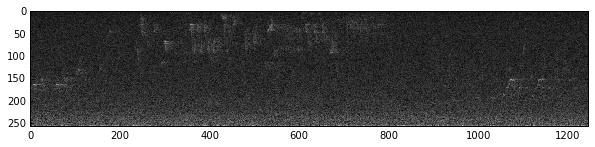

In [9]:
# Pick your image
#image_path = caffe_root + 'examples/images/cat.jpg'
image_path = '../data/MLSP 2013/mlsp_contest_dataset/supplemental_data/spectrograms/PC1_20090705_070000_0040.bmp'
#image_path = '../data/recordings/chickadee funny noise, other chirp song sparrow.wav'

image = caffe.io.load_image(image_path)
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [10]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

# perform classification (slow, ~secs)
output = net.forward()

output_prob = output['prob'][0] # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 885


The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels..."

In [11]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'probabilities and labels:'
top_inds = output_prob.argsort()[::-1][:20] # top k predictions from softmax output
pprint(zip(output_prob[top_inds], labels[top_inds]))

probabilities and labels:
[(0.15045533, 'n04525038 velvet'),
 (0.13852249, 'n03223299 doormat, welcome mat'),
 (0.12479795, 'n03207743 dishrag, dishcloth'),
 (0.08279831, 'n04599235 wool, woolen, woollen'),
 (0.033983503, 'n03887697 paper towel'),
 (0.022745488, 'n03530642 honeycomb'),
 (0.022661999, 'n04376876 syringe'),
 (0.016129013,
  'n03000247 chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour'),
 (0.011925566, 'n03998194 prayer rug, prayer mat'),
 (0.011500423, 'n02114855 coyote, prairie wolf, brush wolf, Canis latrans'),
 (0.01124437, 'n04332243 strainer'),
 (0.011015759, 'n02454379 armadillo'),
 (0.0097646723, 'n02120505 grey fox, gray fox, Urocyon cinereoargenteus'),
 (0.0097130509, 'n04589890 window screen'),
 (0.0090373242, 'n02219486 ant, emmet, pismire'),
 (0.0090282969, 'n02786058 Band Aid'),
 (0.0074922051, 'n03000134 chainlink fence'),
 (0.0073114005, 'n01756291 sidewinder, horned rattlesnake, Crotalus cerastes'),
 (0.0071736509, 'n03717622

Topologies of common networks:
- http://ethereon.github.io/netscope/#/preset/alexnet
- http://ethereon.github.io/netscope/#/preset/caffenet
- http://ethereon.github.io/netscope/#/preset/googlenet
- http://ethereon.github.io/netscope/#/preset/vgg-16

In [12]:
# For each layer, show the shapes of the activations and params:
#   blob       activations  (batch_size, channel_dim, height, width) -- typically, but not always
#   params[0]  weights      (output_channels, input_channels, filter_height, filter_width)
#   params[1]  biases       (output_channels,)

def show_shape(shape, name, fields):
    return '%s(%s)' % (name, ', '.join(['%s=%s' % (d,s) for (s,d) in zip(shape, fields)]))

for layer_name, blob in net.blobs.iteritems():
    [param_weights, param_biases] = net.params.get(layer_name, [None, None])
    print '%-52s %-29s %-31s %s' % (
        layer_name,
        show_shape(blob.data.shape, 'act', ('b', 'c', 'h', 'w')),
        param_weights and show_shape(param_weights.data.shape, 'weight', ('o', 'i', 'h', 'w')) or '',
        param_biases  and show_shape(param_biases.data.shape,  'bias',   ('o', 'i', 'h', 'w')) or '',
    )

data                                                 act(b=50, c=3, h=227, w=227)                                  
conv1                                                act(b=50, c=96, h=55, w=55)   weight(o=96, i=3, h=11, w=11)   bias(o=96)
pool1                                                act(b=50, c=96, h=27, w=27)                                   
norm1                                                act(b=50, c=96, h=27, w=27)                                   
conv2                                                act(b=50, c=256, h=27, w=27)  weight(o=256, i=48, h=5, w=5)   bias(o=256)
pool2                                                act(b=50, c=256, h=13, w=13)                                  
norm2                                                act(b=50, c=256, h=13, w=13)                                  
conv3                                                act(b=50, c=384, h=13, w=13)  weight(o=384, i=256, h=3, w=3)  bias(o=384)
conv4                                   

In [13]:
def norm(data):
    return (data - data.min()) / (data.max() - data.min())

def tile(data, w = np.sqrt):

    n = data.shape[0]
    w = int(np.ceil(w(n)))
    h = int(np.ceil(n / float(w)))
    padding = (
        ((0, h*w-n), (0, 1), (0, 1))  # add some space between filters
        + ((0, 0),) * (data.ndim - 3) # don't pad the last dimension (if there is one)
    )
    data = np.pad(data, padding, mode='constant', constant_values=1)# pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((h,w) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((h * data.shape[1], w * data.shape[3]) + data.shape[4:])
    return data
    
def vis_pretiled(data):
    plt.figure(figsize = (29, 29*6)) # scale to fit within 17in width x 10in height
    print 'vis_pretiled: data.shape[%s]' % (data.shape,) # XXX
    plt.imshow(data)
    plt.axis('off')
    plt.show() # So we can have multiple plt.imshow's from the same cell

def vis_square(data, w = np.sqrt):
    'data: an array of shape (n, height, width) or (n, height, width, 3)'
    vis_pretiled(tile(norm(data), w))
    
def TODO_tiled(data, w = np.sqrt):
    return tile(norm(data), w)

def tile_tiles(data, w_filters_per_tile = np.sqrt):
    print 'tile_tile: data.shape[%s]' % (data.shape,)

    # Calculate our various widths (w_*)
    w_pixels_per_figure = 400
    (n_out, n_in, h_pixels_per_filter, w_pixels_per_filter) = data.shape
    w_filters_per_tile = int(np.ceil(w_filters_per_tile(n_in)))
    w_tiles_per_figure = w_pixels_per_figure / w_filters_per_tile / w_pixels_per_filter

    return tile(
        w    = lambda n: w_tiles_per_figure,
        data = np.array(map(
            w    = lambda xs: tile(lambda n: w_filters_per_tile, xs),
            data = np.array(map(norm, data)),
        )),
    )

vis_pretiled: data.shape[(60, 240, 3)]


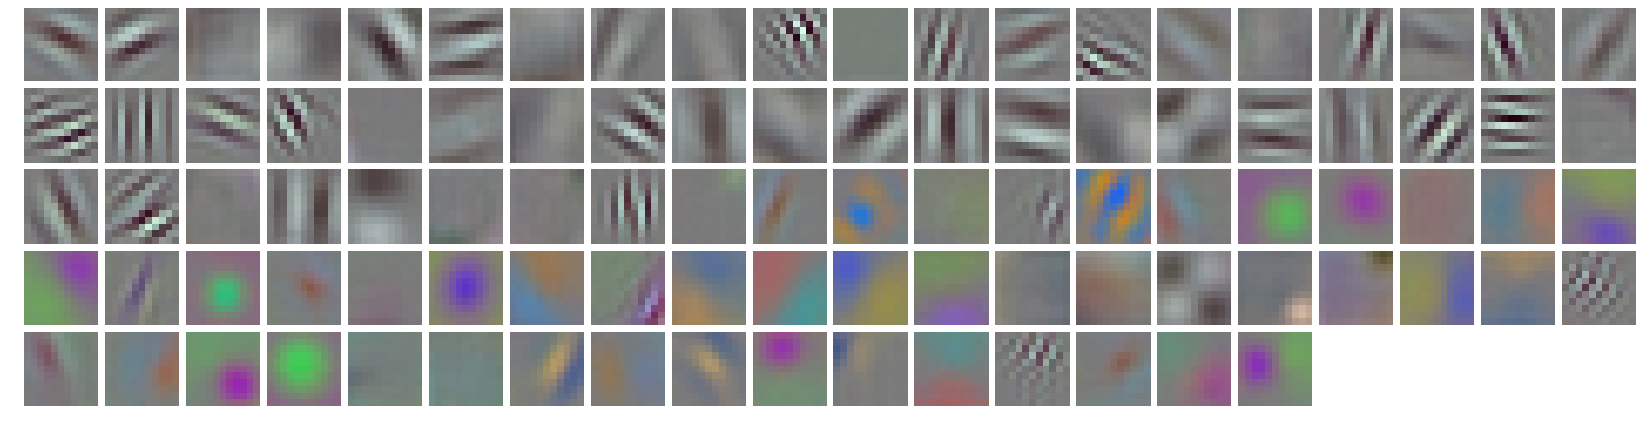

In [14]:
vis_pretiled(TODO_tiled(net.params['conv1'][0].data.transpose(0,2,3,1), lambda n: 20))

In [16]:
#vis_pretiled(tile_tiles(net.params['conv2'][0].data))
#vis_pretiled(tile_tiles(net.params['conv3'][0].data))
#vis_pretiled(tile_tiles(net.params['conv4'][0].data))
#vis_pretiled(tile_tiles(net.params['conv5'][0].data))

In [17]:
## TODO Backup before modifying above
#
#def norm(data):
#    return (data - data.min()) / (data.max() - data.min())
#
#def tile(aspect, data):
#    orig_shape = data.shape
#
#    # Decompose n = w*h where w/h = aspect
#    n = data.shape[0]
#    w  = int(np.ceil(np.sqrt(n / float(aspect))))
#    #h = int(np.ceil(np.sqrt(n * float(aspect)))) # Correct approximation to h/w = aspect
#    h  = int(np.ceil(n / float(w)))               # Smaller h that avoids O(w) blank space at the bottom
#    padding = (
#        ((0, w*h-n), (0, 1), (0, 1))  # add some space between filters
#        + ((0, 0),) * (data.ndim - 3) # don't pad the last dimension (if there is one)
#    )
#    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
#    
#    # tile the filters into an image
#    data = data.reshape((h,w) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
#    data = data.reshape((h * data.shape[1], w * data.shape[3]) + data.shape[4:])
#    
#    print 'tile_data shape: %s -> %s' % (orig_shape, data.shape)
#    return data
#    
#def vis_pretiled(data):
#    plt.figure(figsize = (17, 100)) # scale to fit within 17in width x 10in height
#    print 'vis_pretiled: data.shape[%s]' % (data.shape,) # XXX
#    plt.imshow(data)
#    plt.axis('off')
#    plt.show() # So we can have multiple plt.imshow's from the same cell
#
#def vis_square(data):
#    'data: an array of shape (n, height, width) or (n, height, width, 3)'
#    vis_pretiled(tile(1, norm(data)))
#
#print net.params['conv2'][0].data.shape
#print net.params['conv2'][0].data.transpose(0,1,2,3).reshape(256*48,5,5).shape
#
#vis_pretiled(tile(1/6.0, tile(1, norm(net.params['conv2'][0].data.transpose(1,2,3,0))).transpose(2,0,1)))
#vis_square(tile(1, net.params['conv2'][0].data.transpose(1,2,3,0)).transpose(2,0,1))
##vis_square(net.params['conv2'][0].data.transpose(0,1,2,3).reshape(256*48,5,5))
#vis_square(net.params['conv2'][0].data.transpose(0,1,2,3)[0])
#vis_square(net.params['conv2'][0].data.transpose(1,0,2,3)[0])
#
#vis_square(net.params['conv1'][0].data.transpose(0,2,3,1)) # (96,3,11,11) -> (96,11,11,3)

In [ ]:
# XXX Merge into below after making this work

for layer_name, params in net.params.iteritems():
    [param_weights, param_biases] = net.params.get(layer_name, [None, None])
    if param_weights:
        print 'layer[%s], param_weights.data.shape[%s]' % (layer_name, param_weights.data.shape)
        try:
            vis_square(param_weights.data.transpose(0, 2, 3, 1)) # e.g. (96,3,11,11) -> (96,11,11,3)
        except Exception, e:
            print '    Error:', e


layer[data]
- blob.data.shape[(50, 3, 227, 227)]
- param_weights.data.shape[None]
- param_biases.data.shape[None]

vis_pretiled: data.shape[(456, 456)]


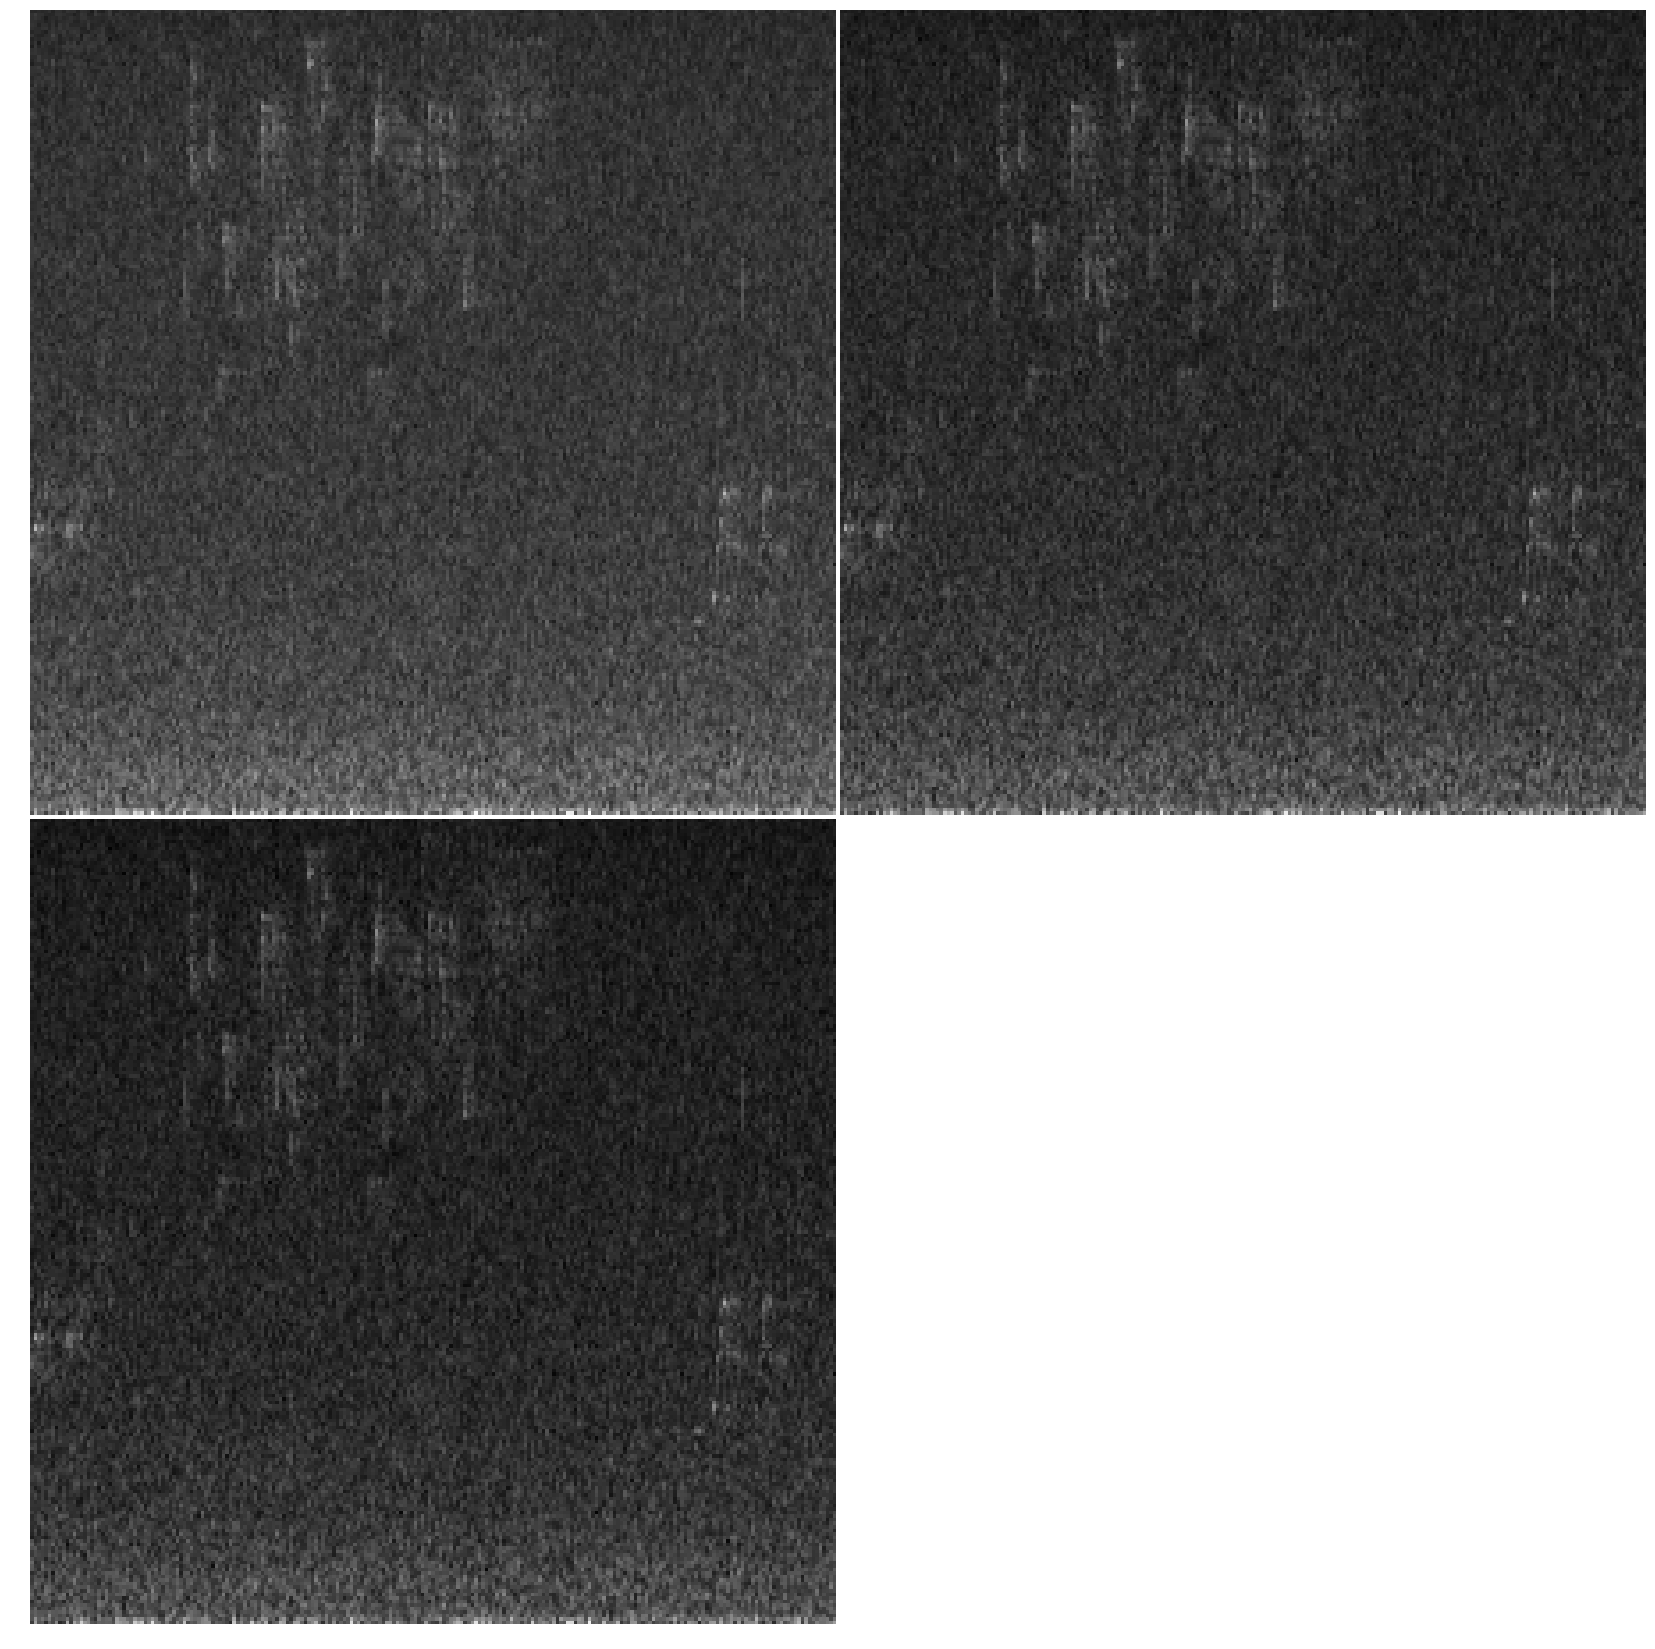

layer[data], param_weights[None]

layer[conv1]
- blob.data.shape[(50, 96, 55, 55)]
- param_weights.data.shape[(96, 3, 11, 11)]
- param_biases.data.shape[(96,)]

vis_pretiled: data.shape[(560, 560)]


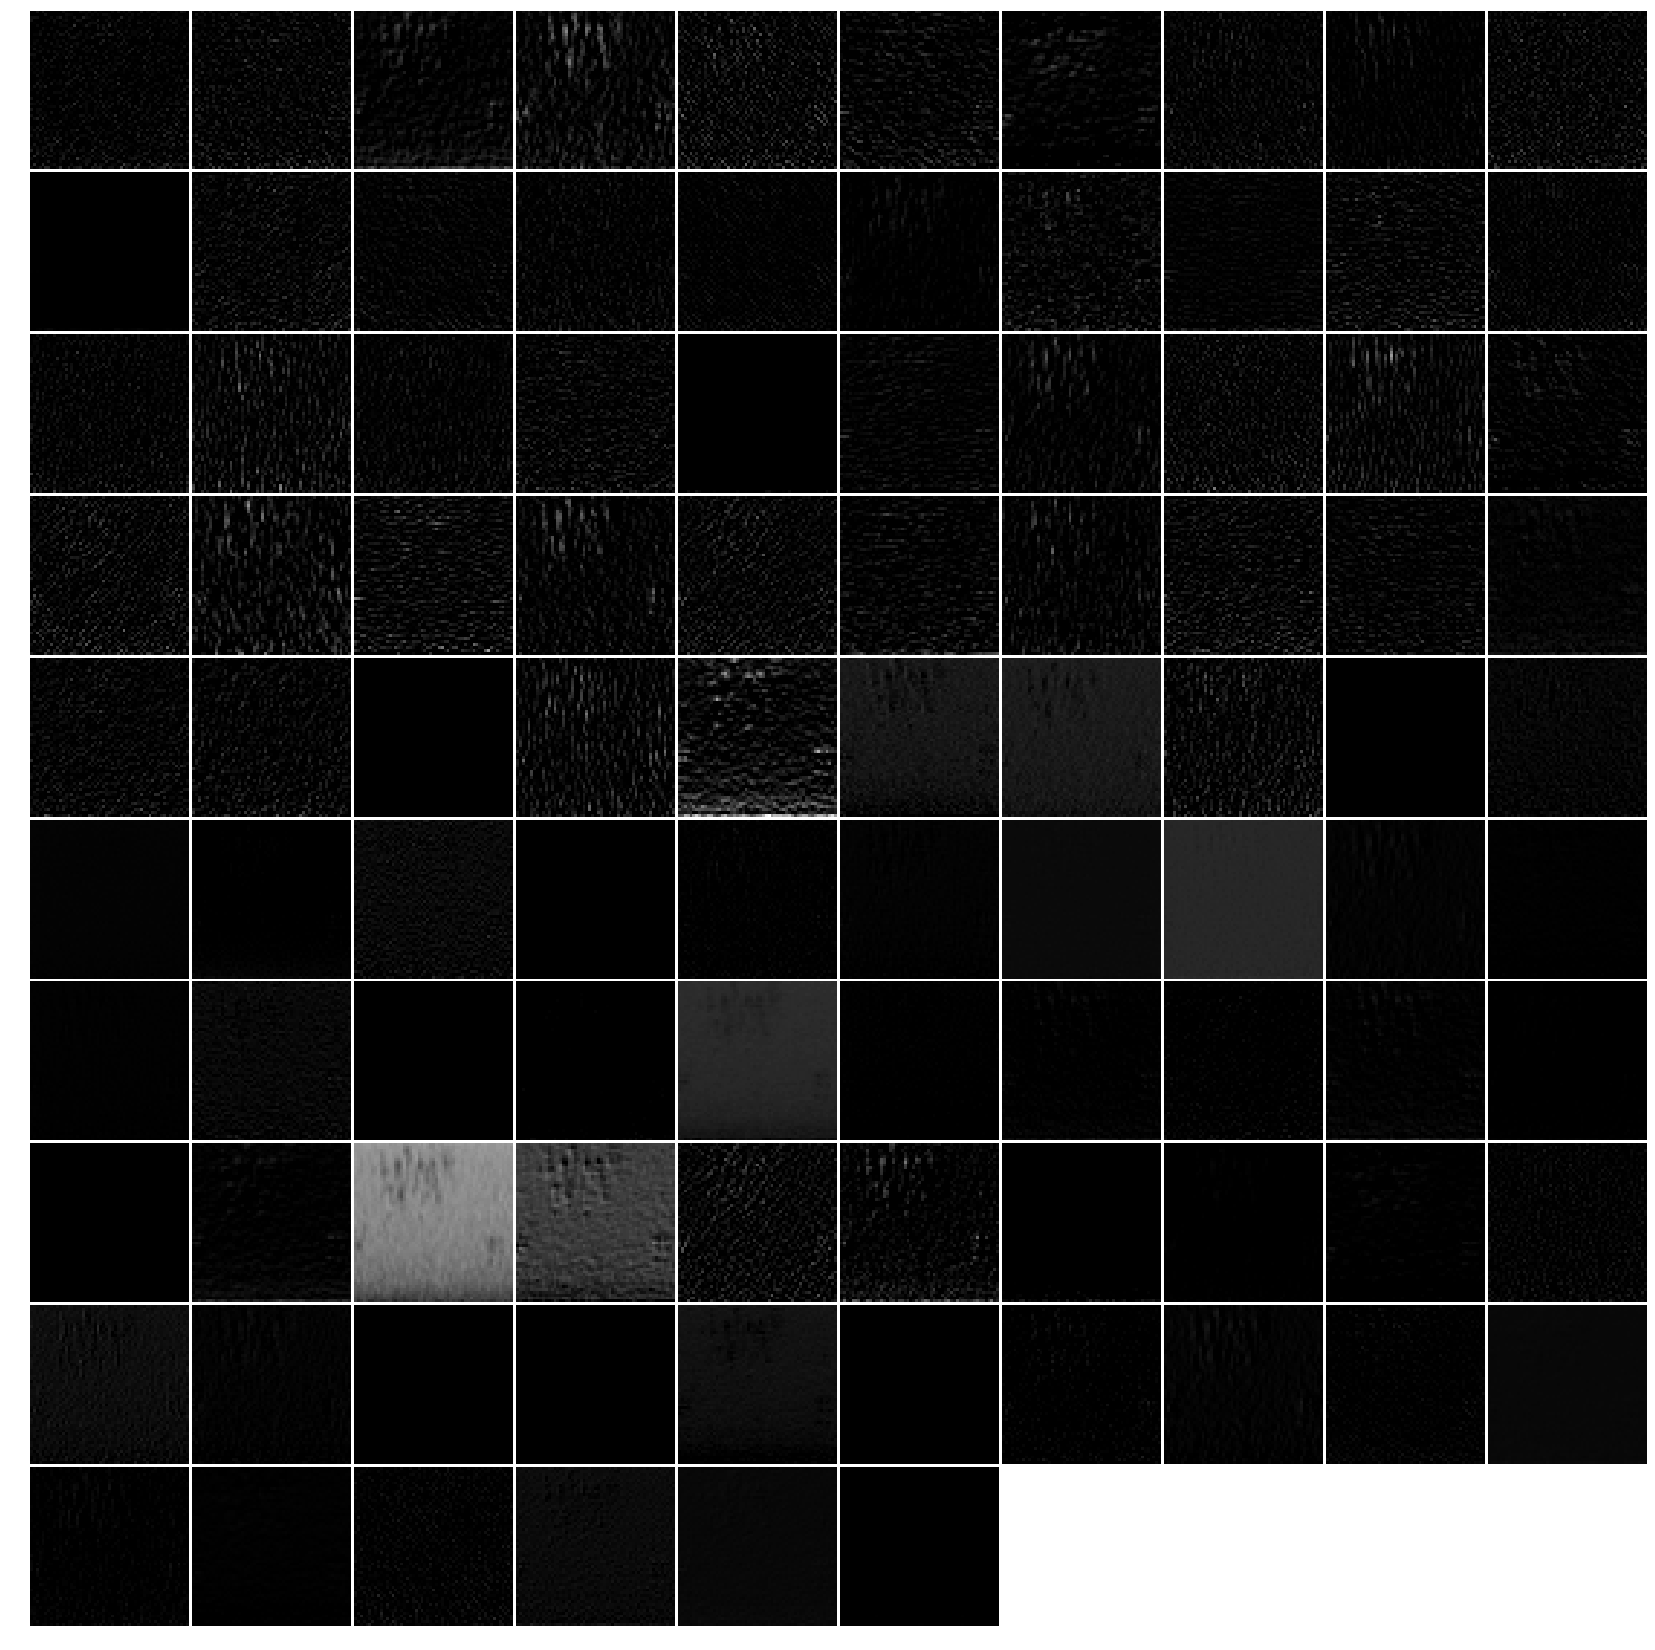

layer[conv1], param_weights.data.shape[(96, 3, 11, 11)]
vis_pretiled: data.shape[(120, 120, 3)]


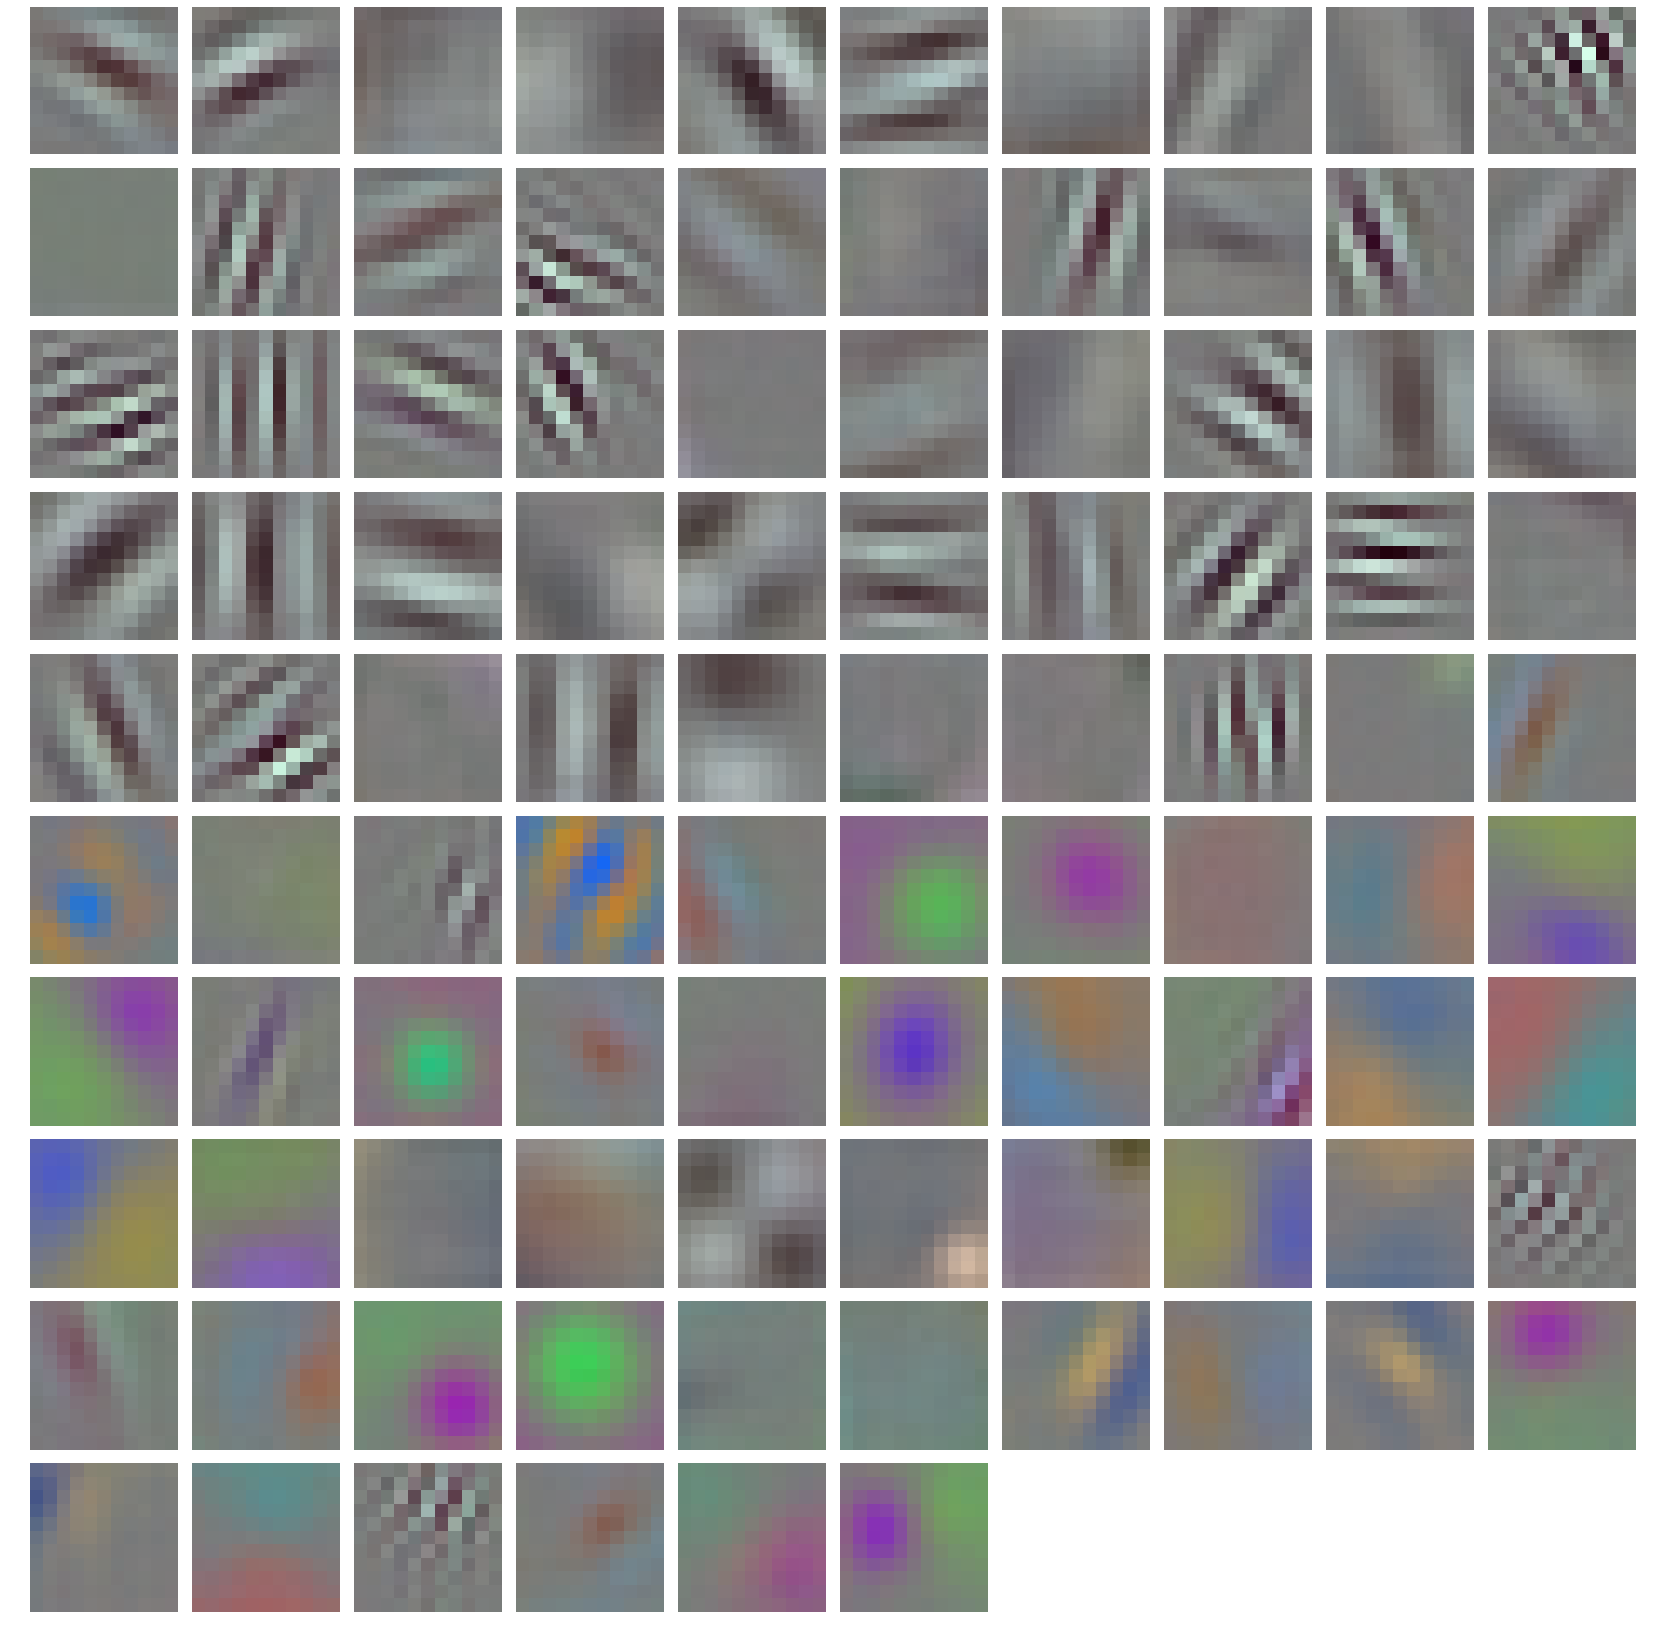


layer[pool1]
- blob.data.shape[(50, 96, 27, 27)]
- param_weights.data.shape[None]
- param_biases.data.shape[None]

vis_pretiled: data.shape[(280, 280)]


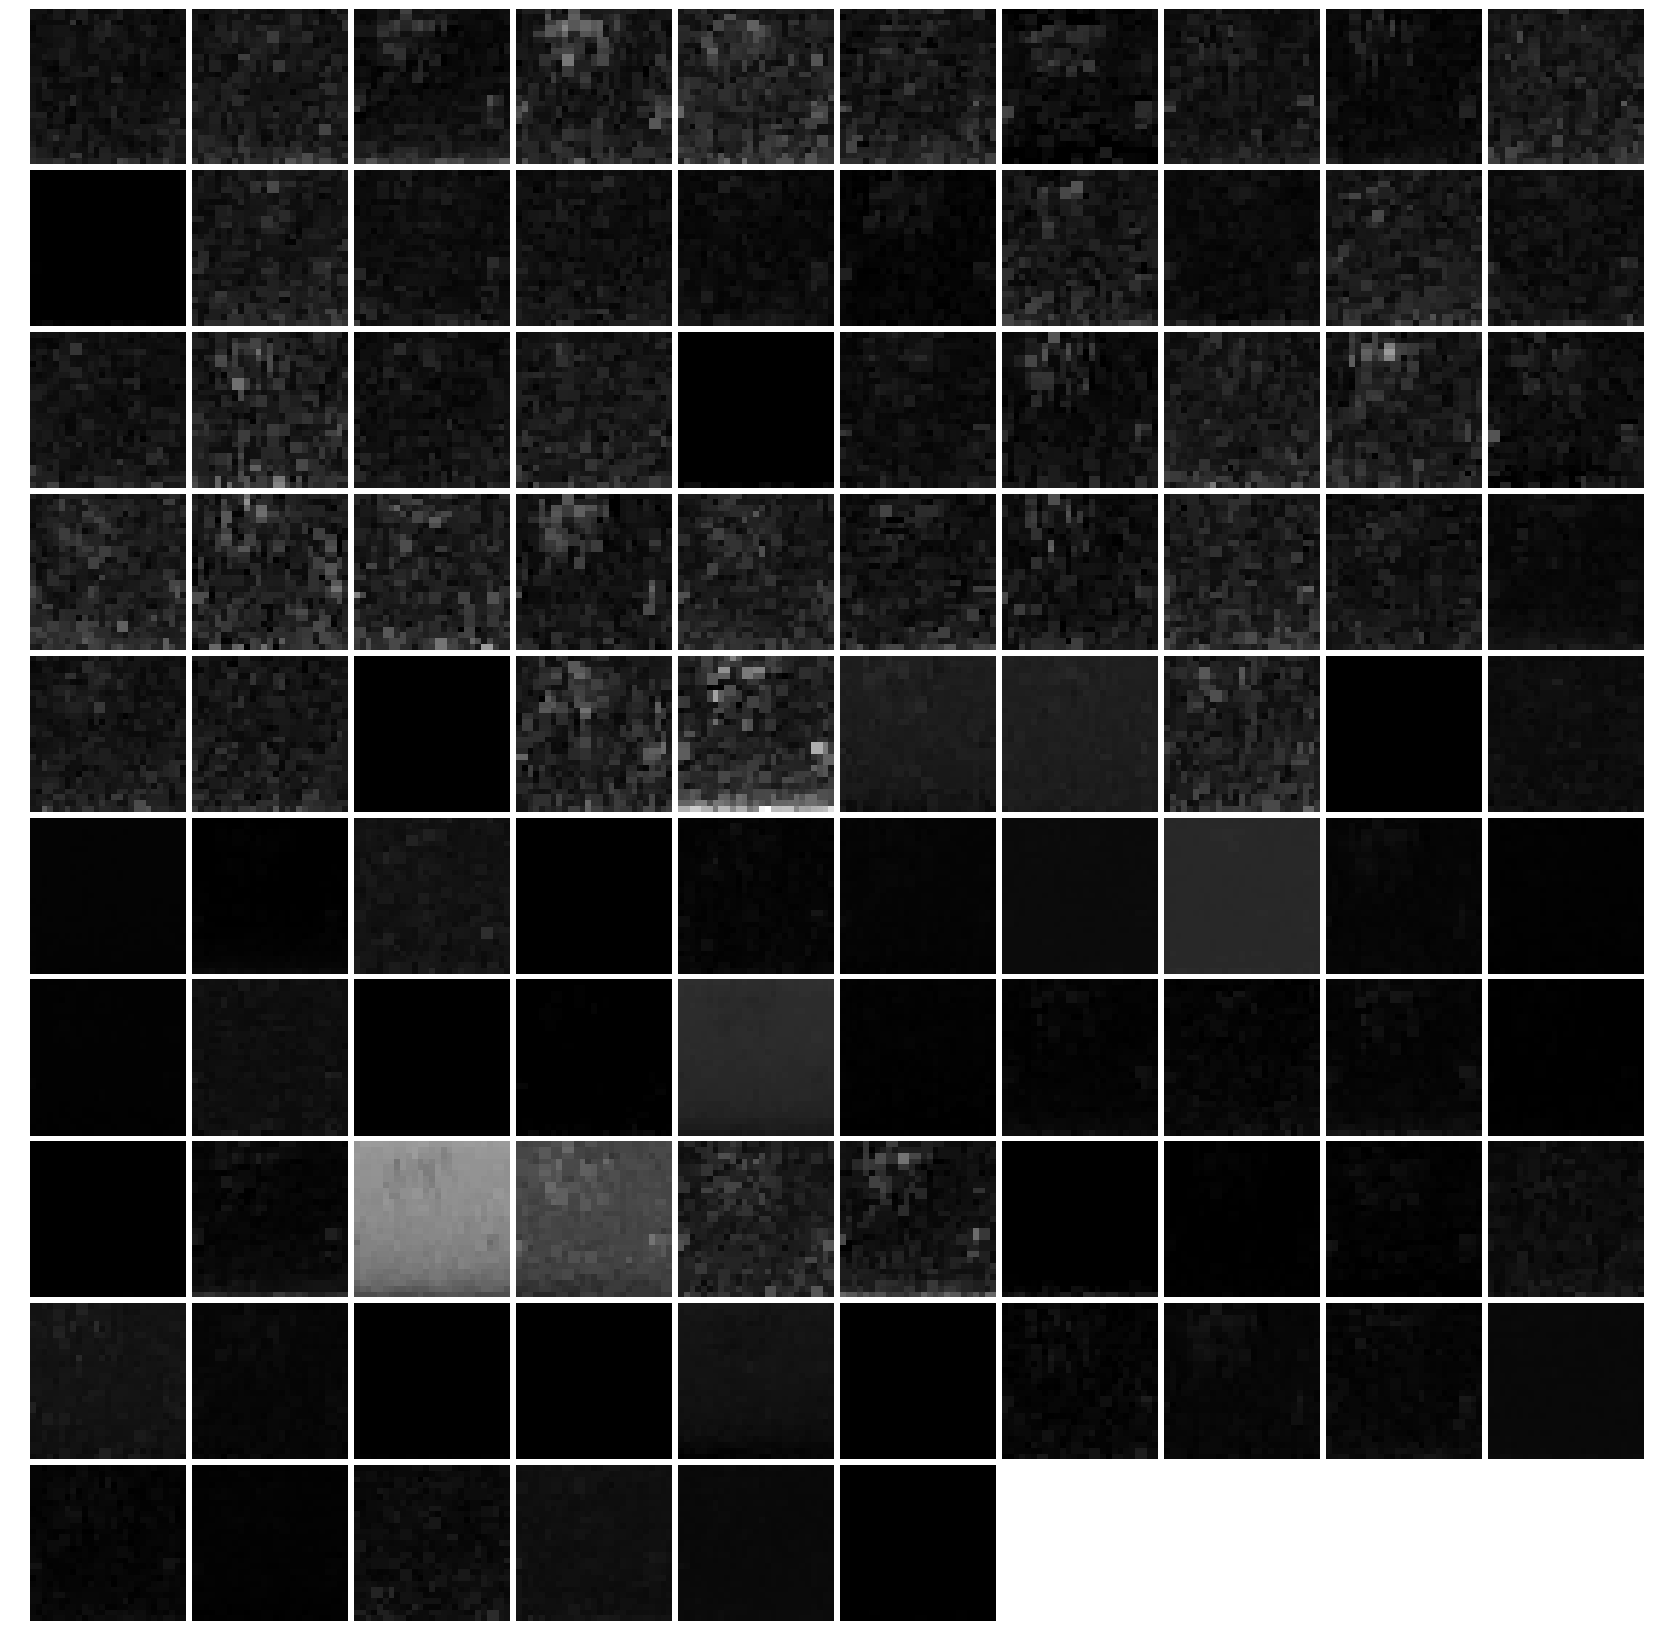

layer[pool1], param_weights[None]

layer[norm1]
- blob.data.shape[(50, 96, 27, 27)]
- param_weights.data.shape[None]
- param_biases.data.shape[None]

vis_pretiled: data.shape[(280, 280)]


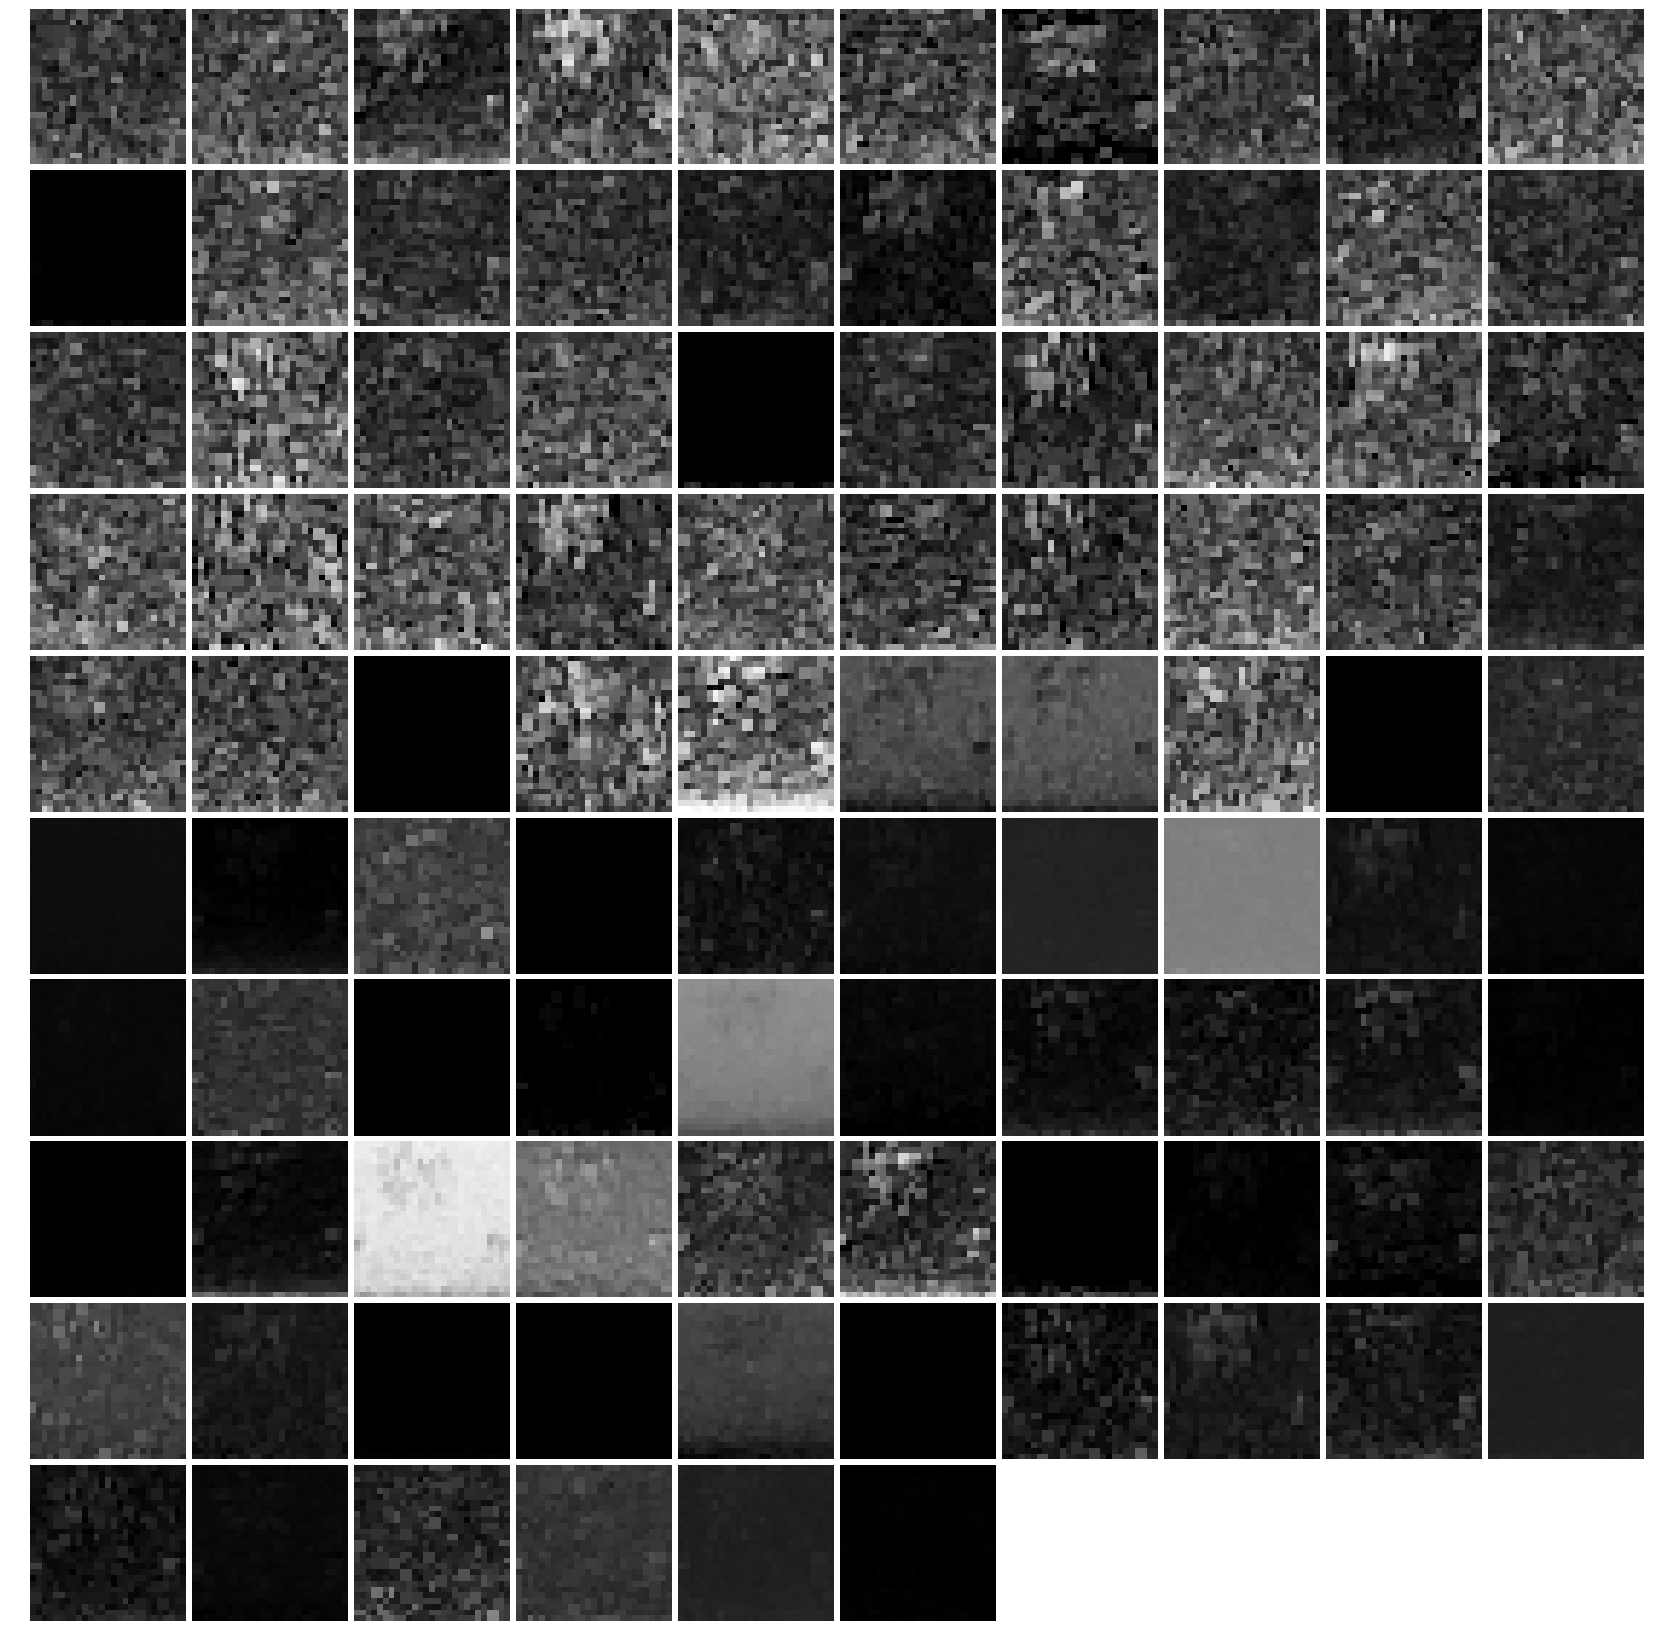

layer[norm1], param_weights[None]

layer[conv2]
- blob.data.shape[(50, 256, 27, 27)]
- param_weights.data.shape[(256, 48, 5, 5)]
- param_biases.data.shape[(256,)]

vis_pretiled: data.shape[(448, 448)]


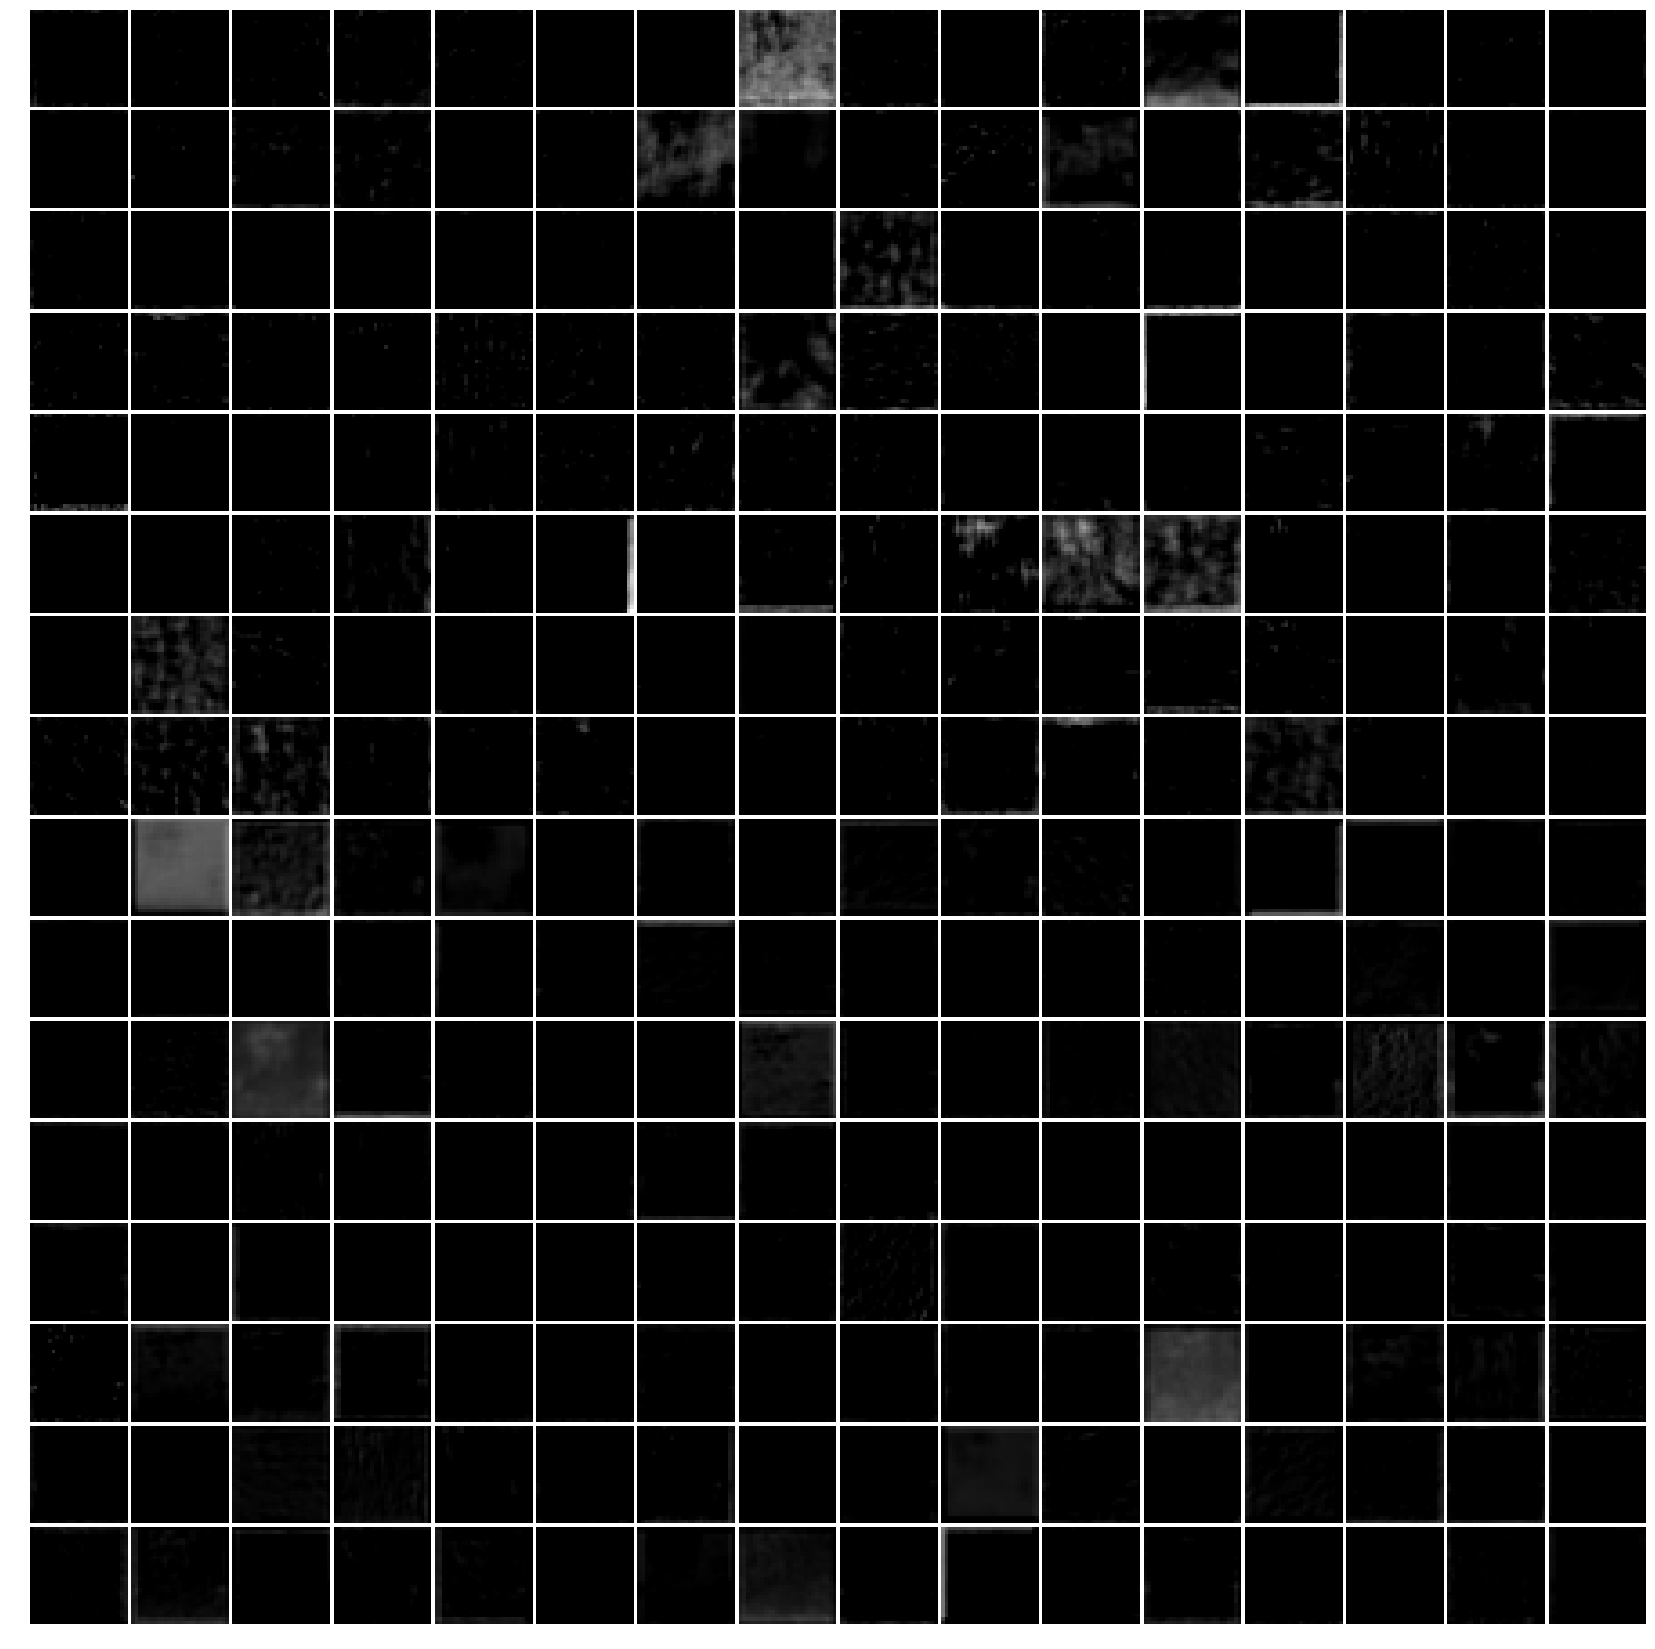

layer[conv2], param_weights.data.shape[(256, 48, 5, 5)]
vis_pretiled: data.shape[(96, 96, 48)]
    Error: Invalid dimensions for image data

layer[pool2]
- blob.data.shape[(50, 256, 13, 13)]
- param_weights.data.shape[None]
- param_biases.data.shape[None]

vis_pretiled: data.shape[(224, 224)]


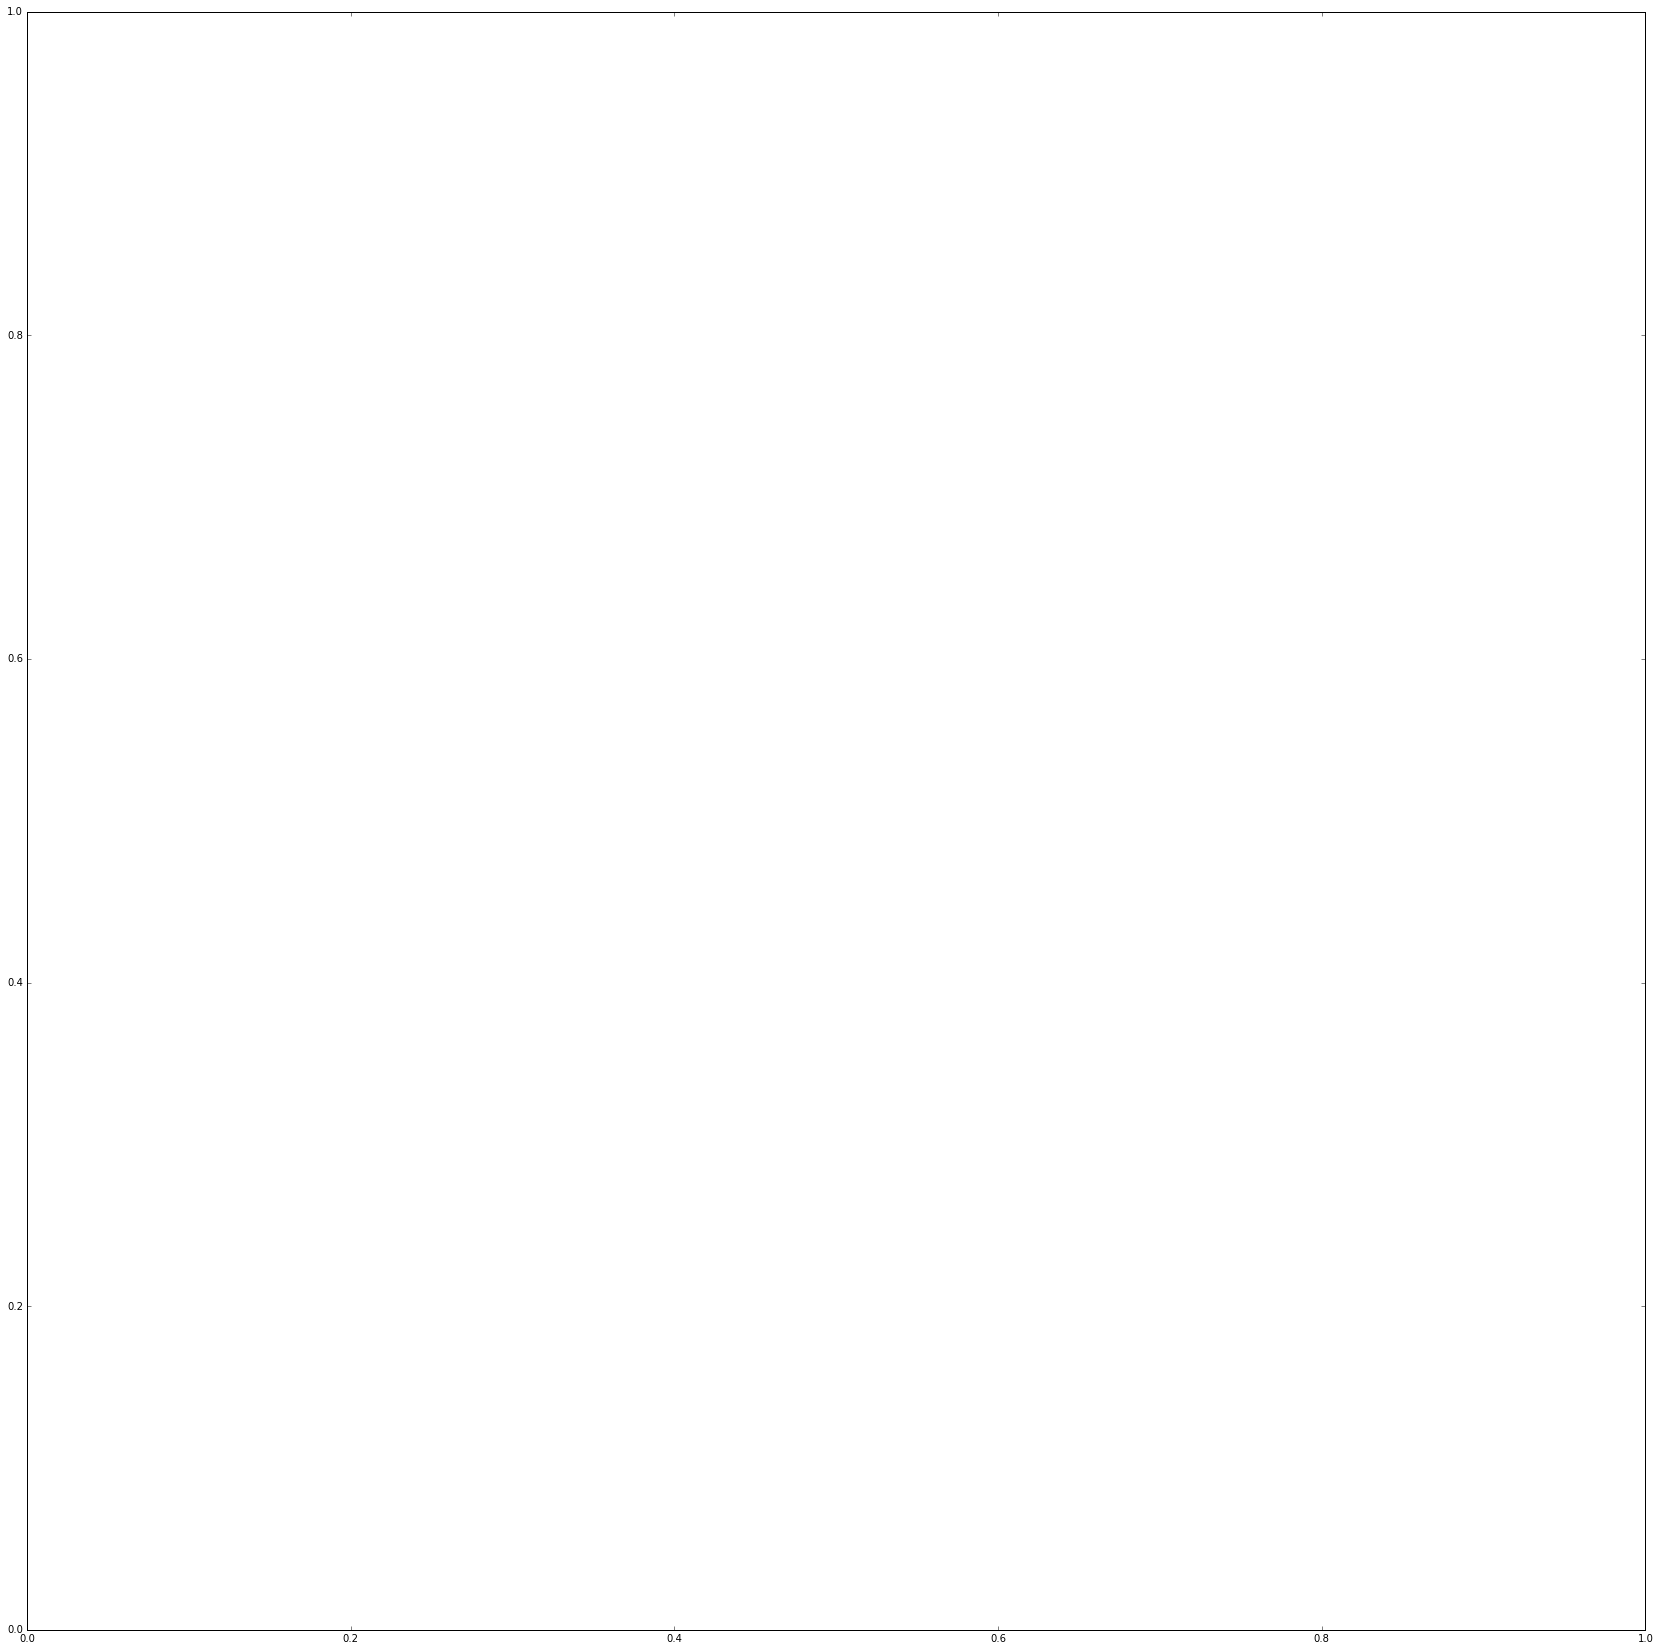

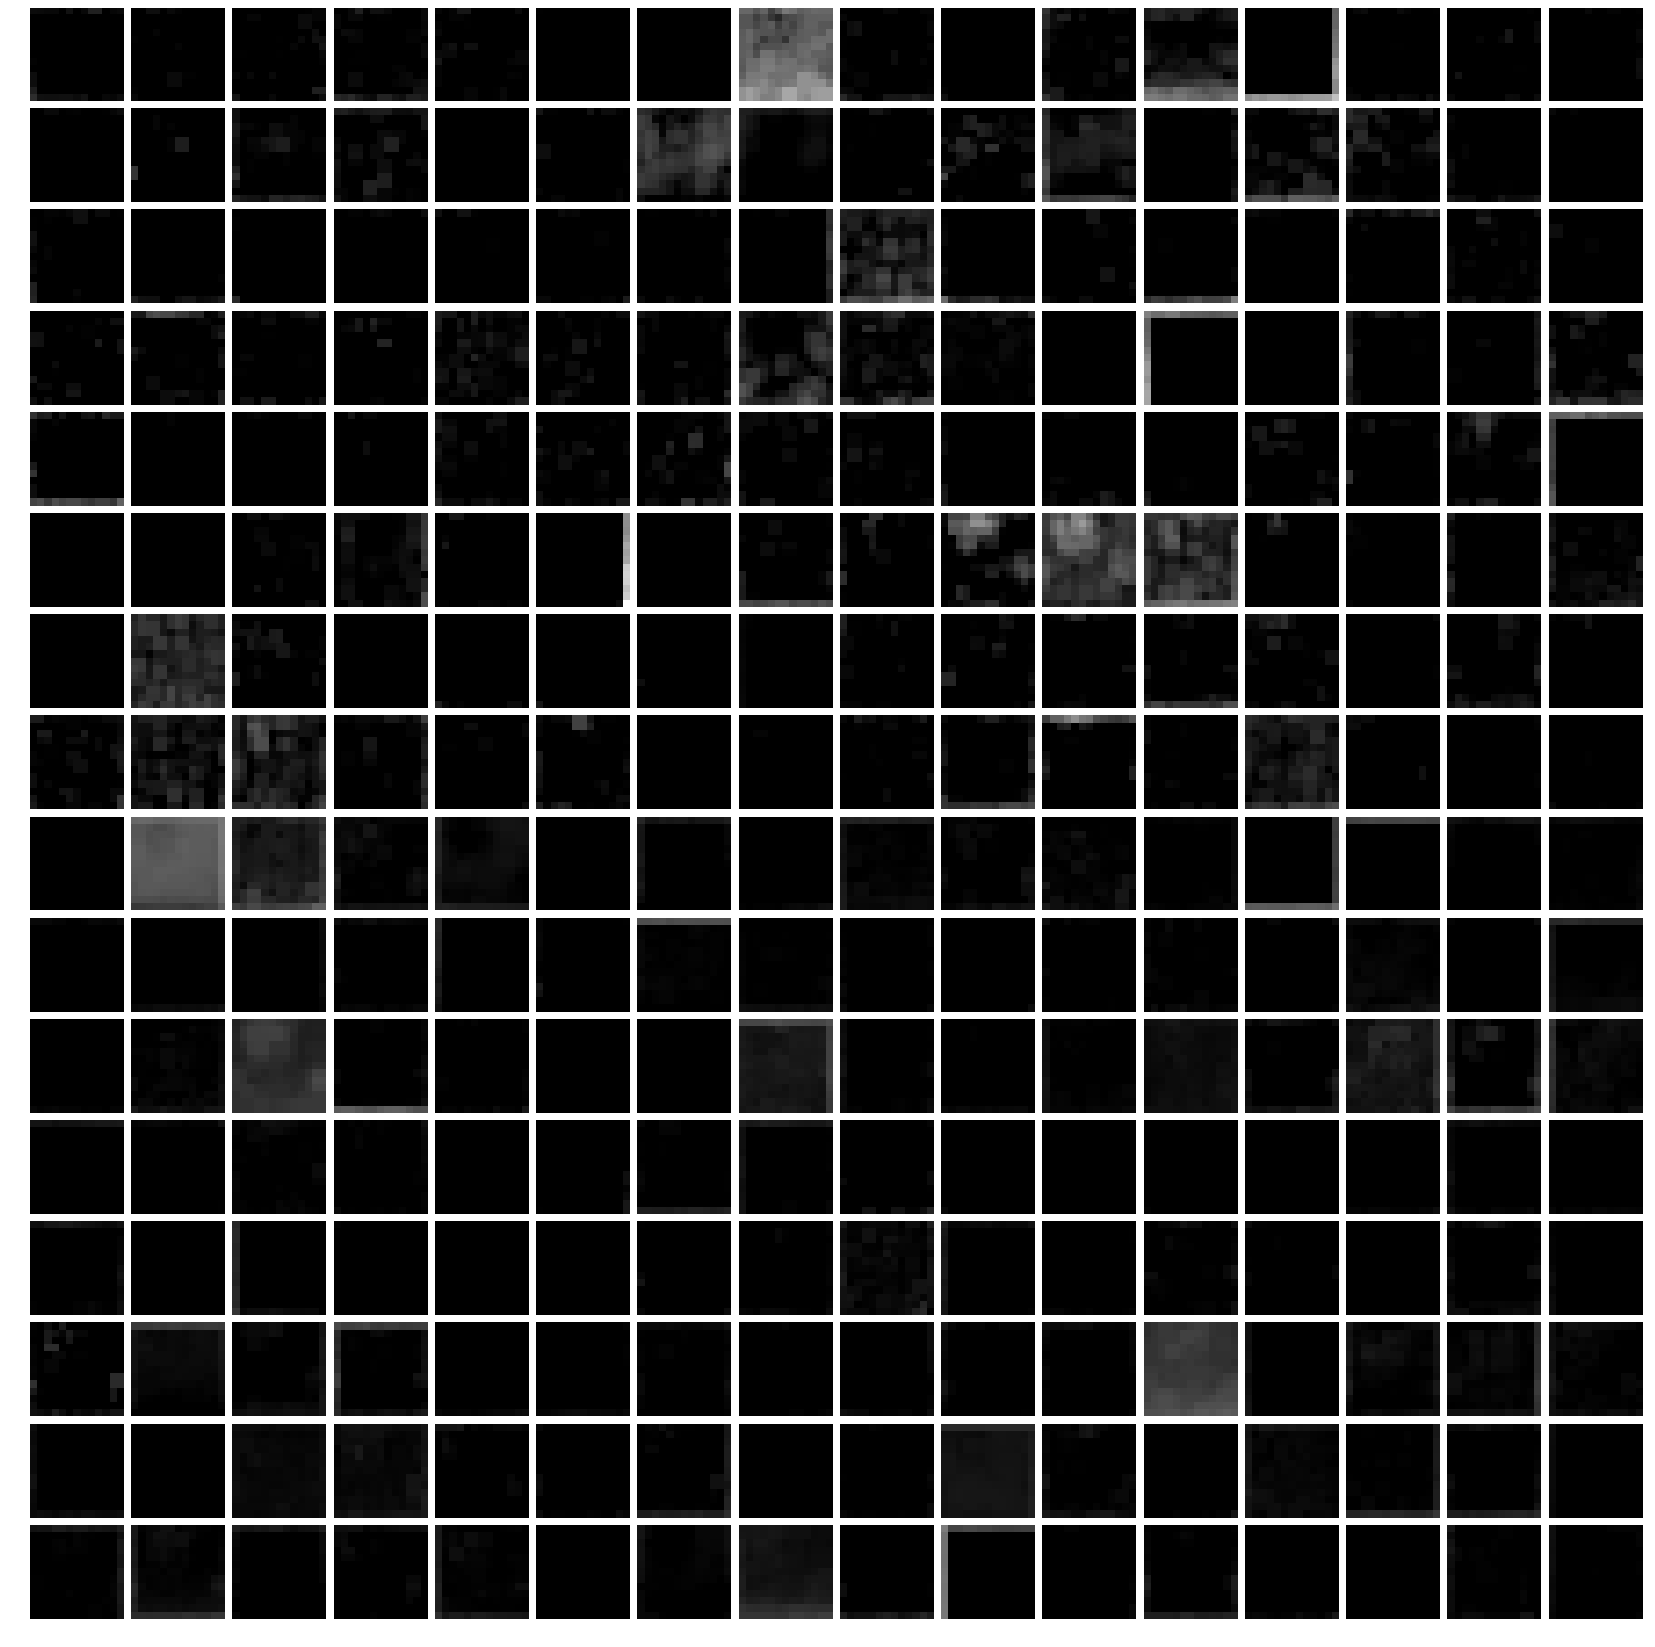

layer[pool2], param_weights[None]

layer[norm2]
- blob.data.shape[(50, 256, 13, 13)]
- param_weights.data.shape[None]
- param_biases.data.shape[None]

vis_pretiled: data.shape[(224, 224)]


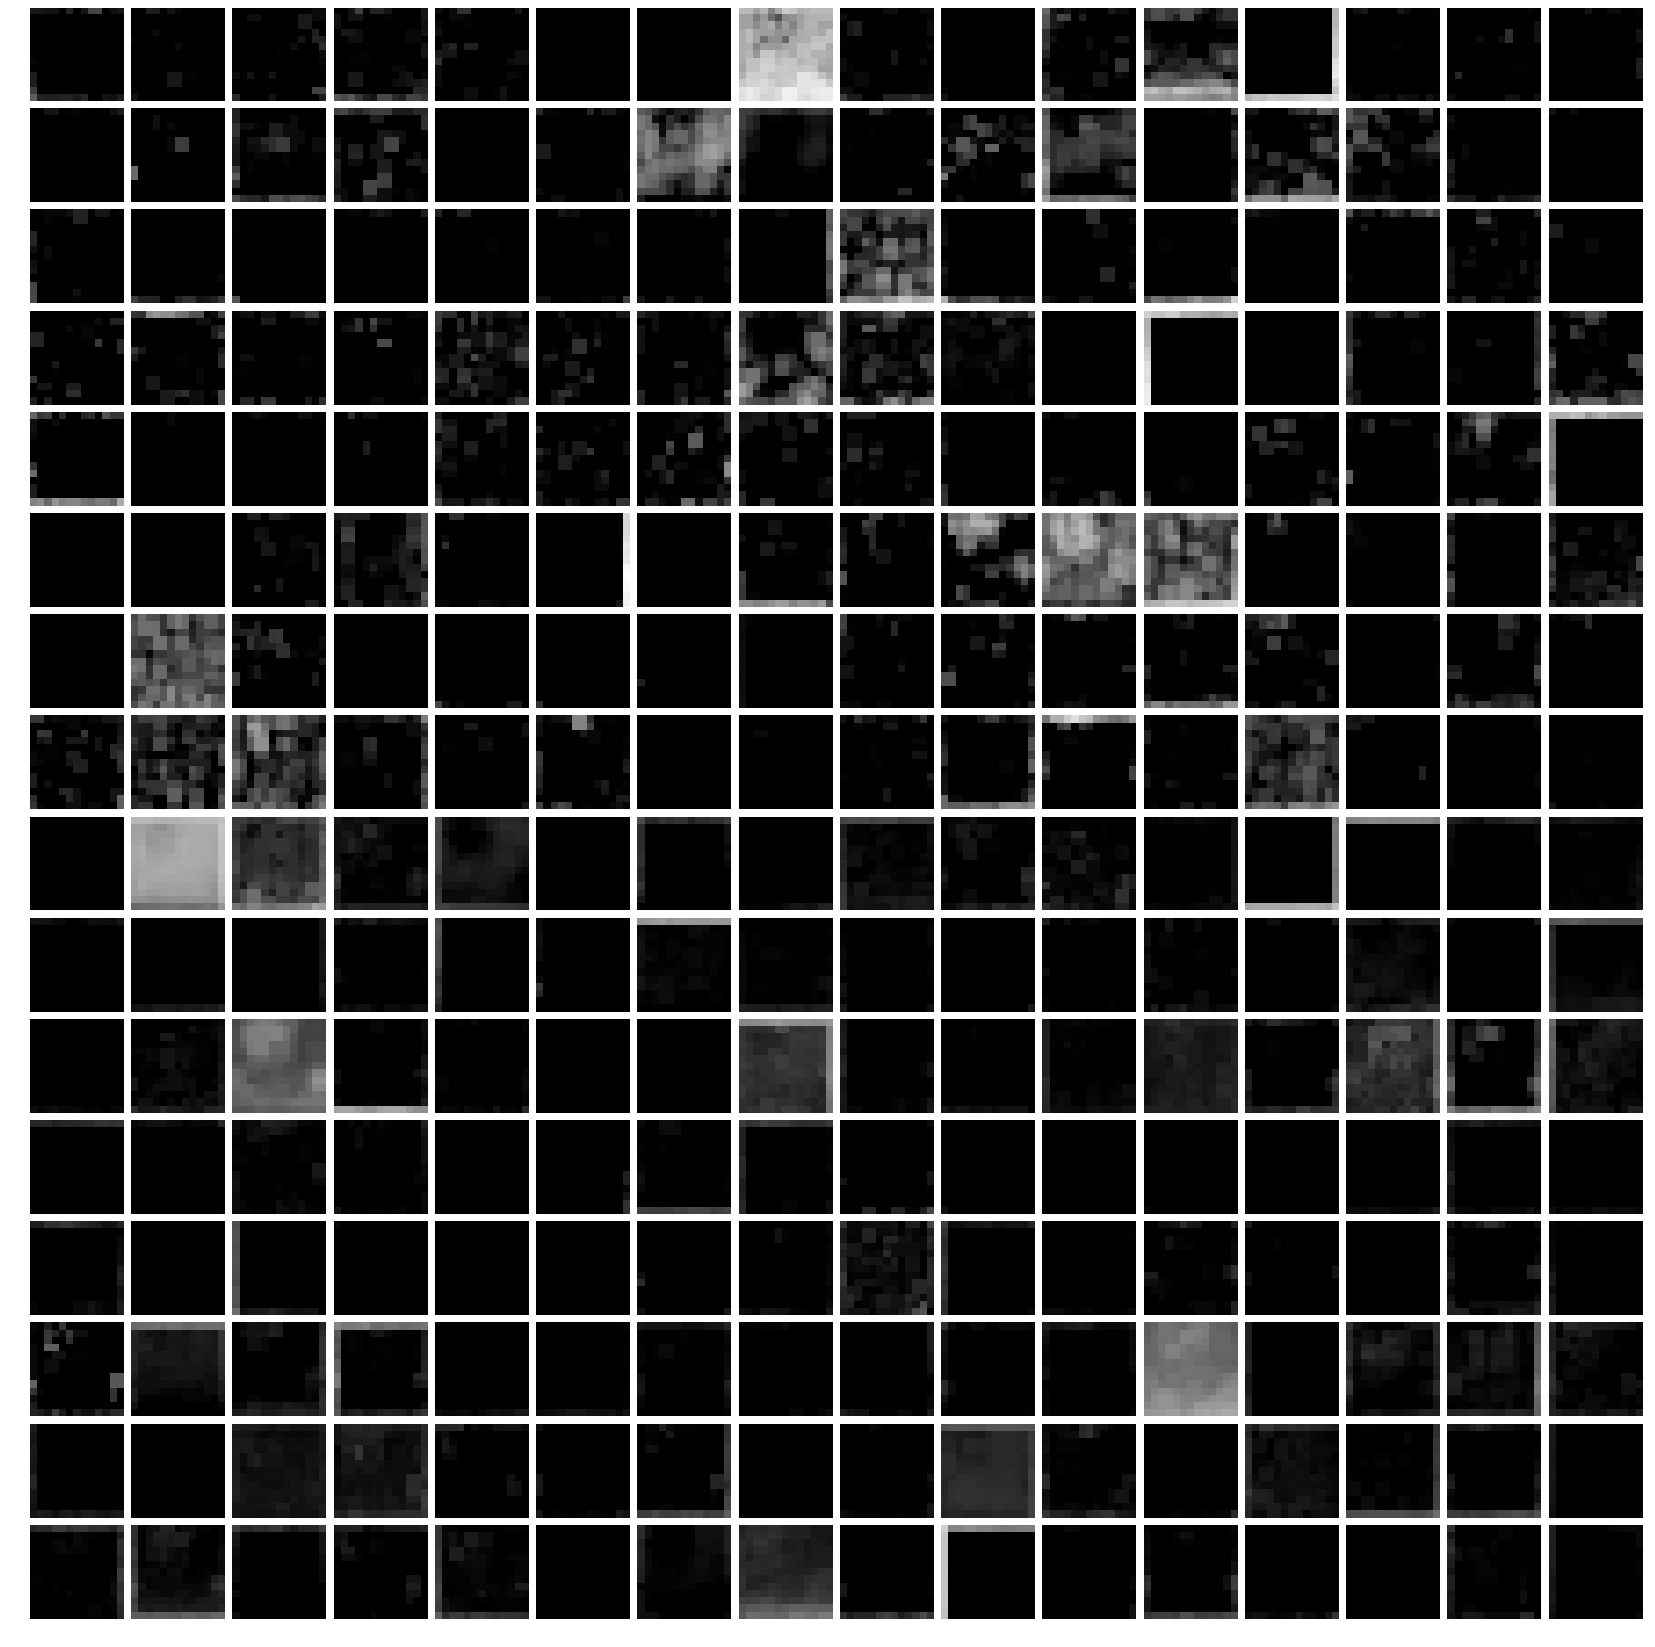

layer[norm2], param_weights[None]

layer[conv3]
- blob.data.shape[(50, 384, 13, 13)]
- param_weights.data.shape[(384, 256, 3, 3)]
- param_biases.data.shape[(384,)]

vis_pretiled: data.shape[(280, 280)]


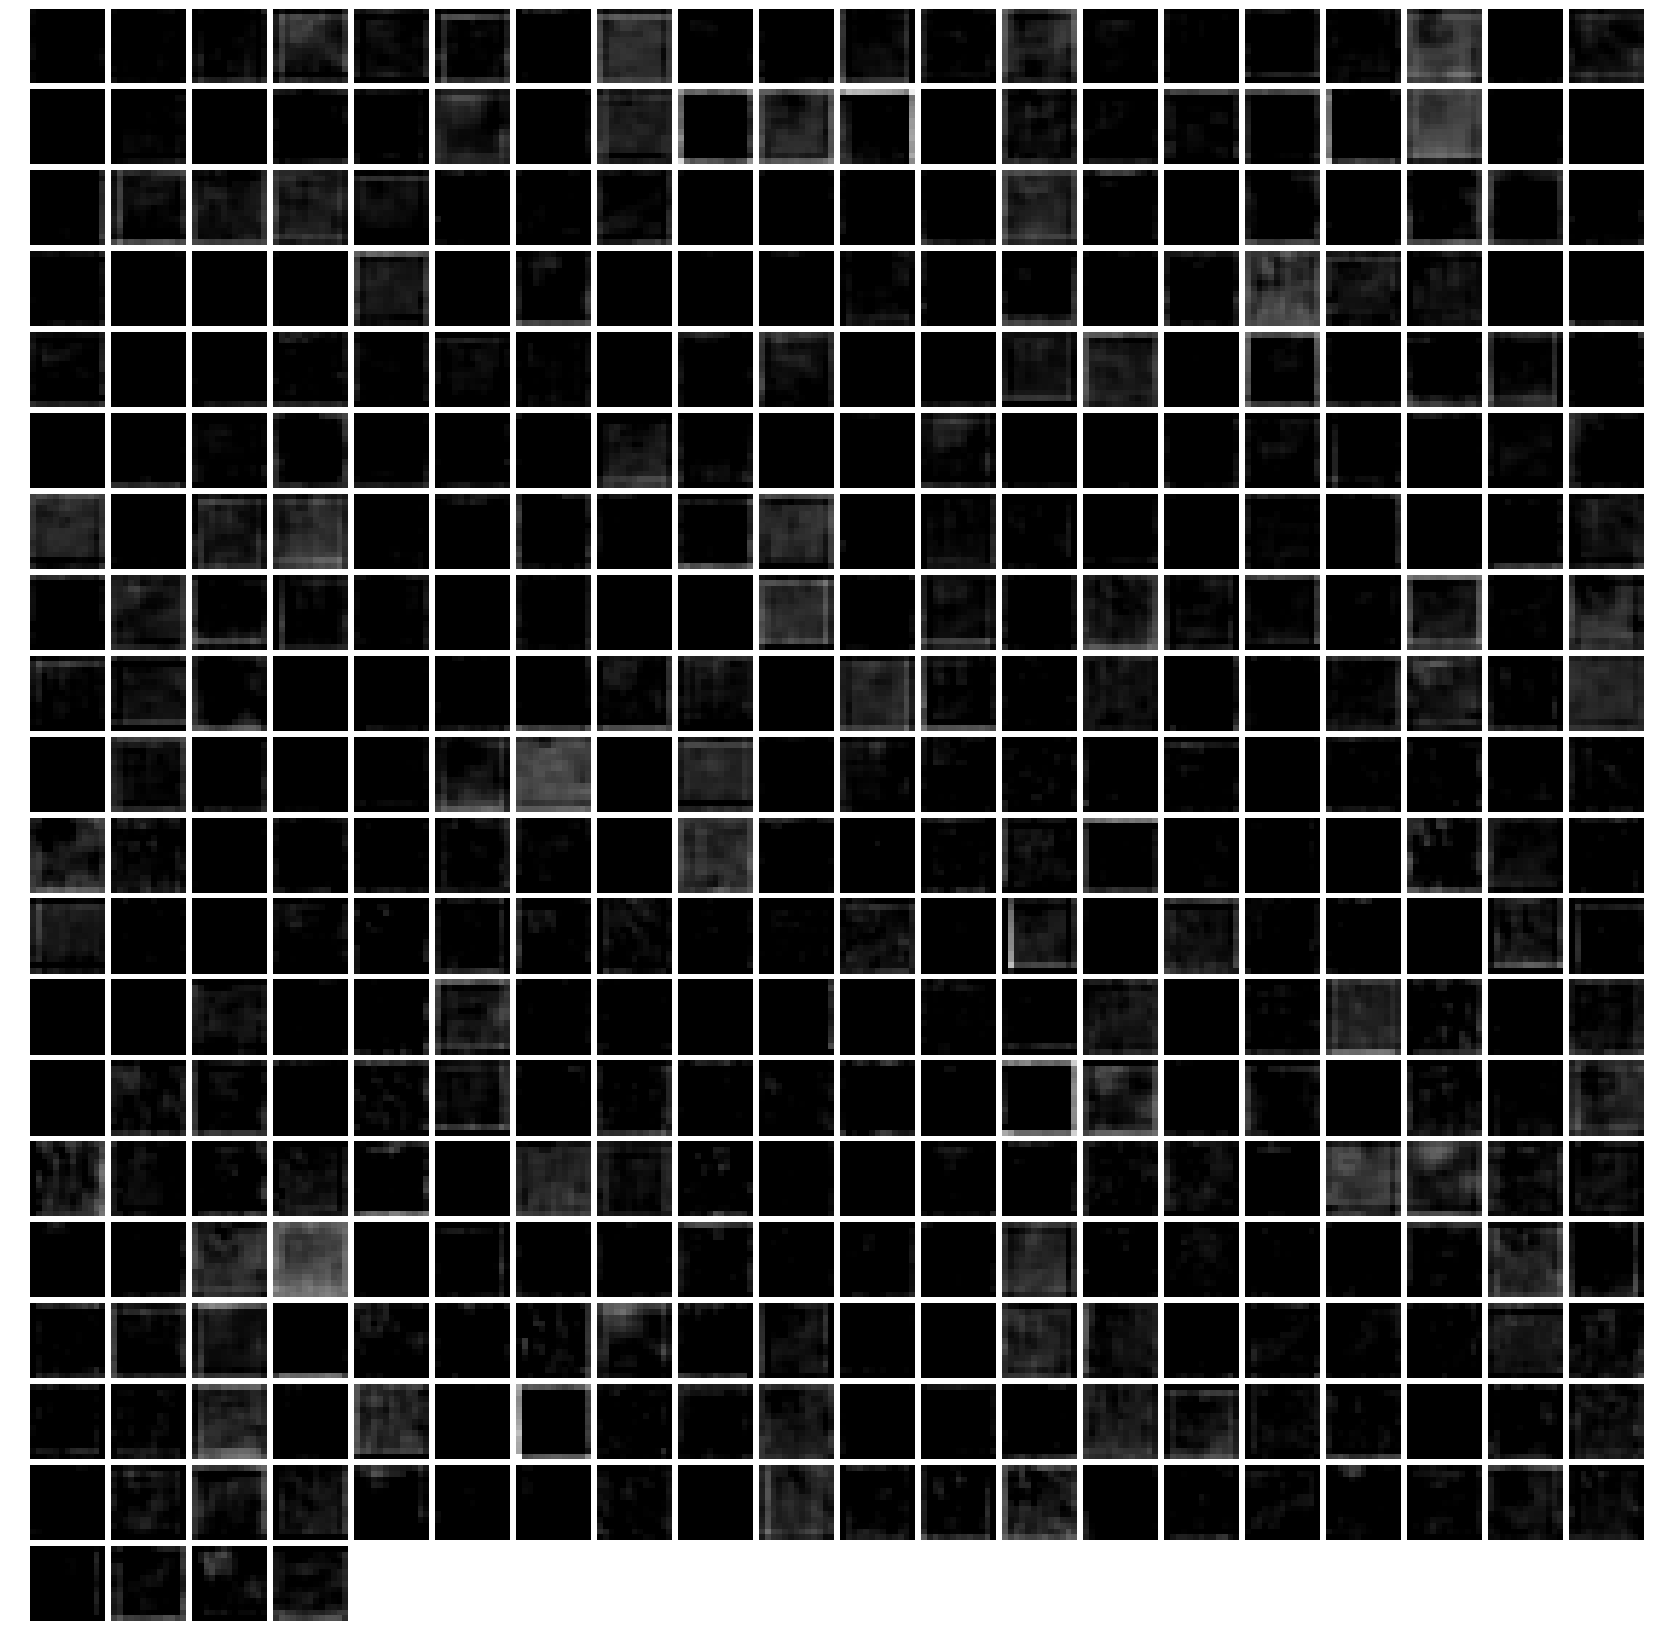

layer[conv3], param_weights.data.shape[(384, 256, 3, 3)]
vis_pretiled: data.shape[(80, 80, 256)]
    Error: Invalid dimensions for image data

layer[conv4]
- blob.data.shape[(50, 384, 13, 13)]
- param_weights.data.shape[(384, 192, 3, 3)]
- param_biases.data.shape[(384,)]

vis_pretiled: data.shape[(280, 280)]


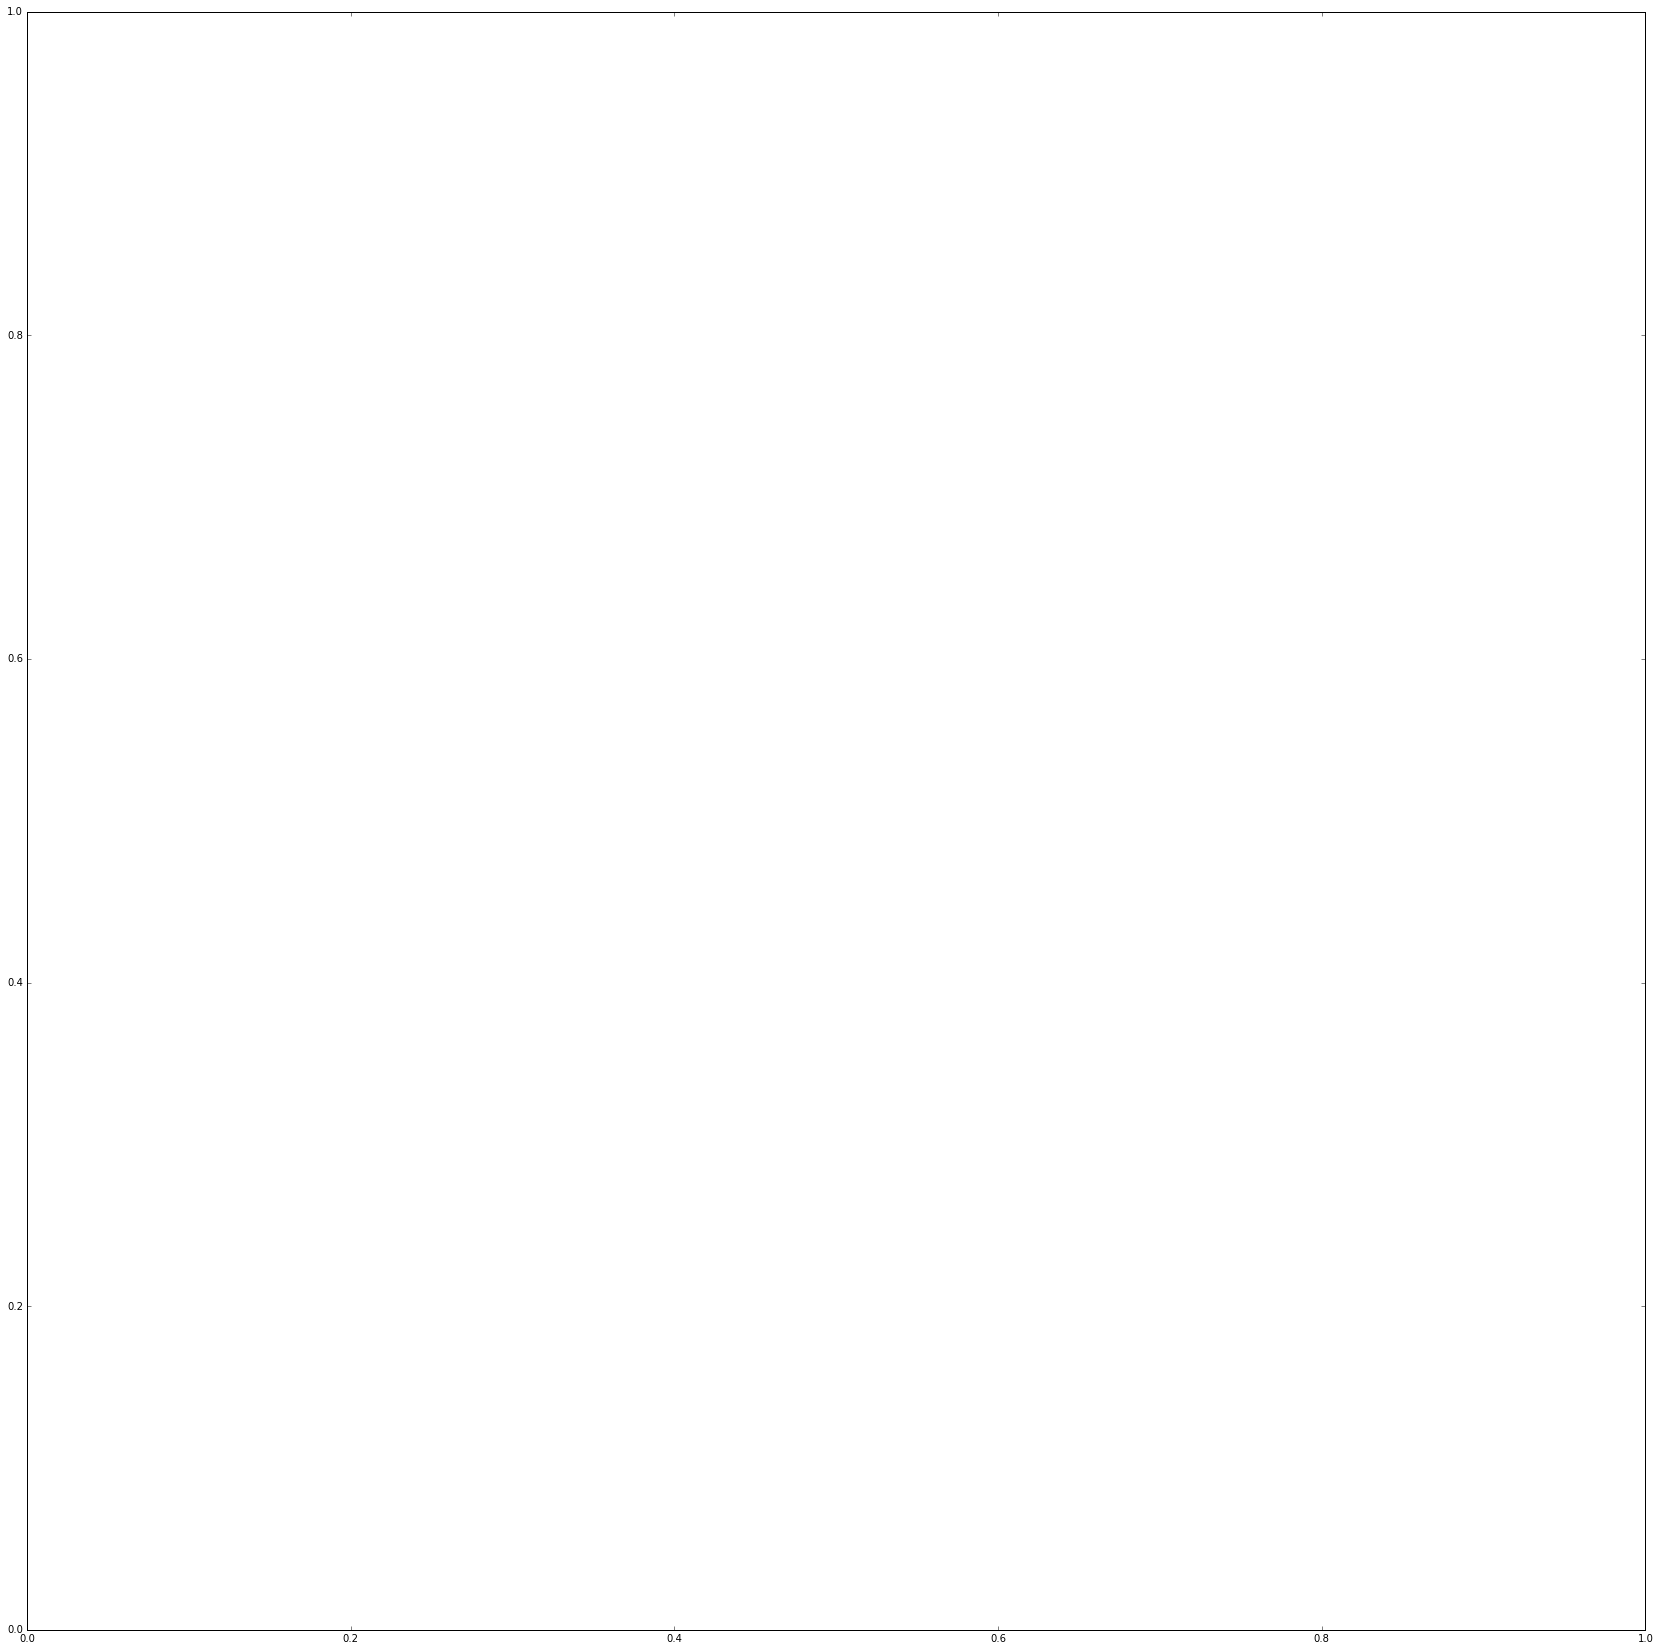

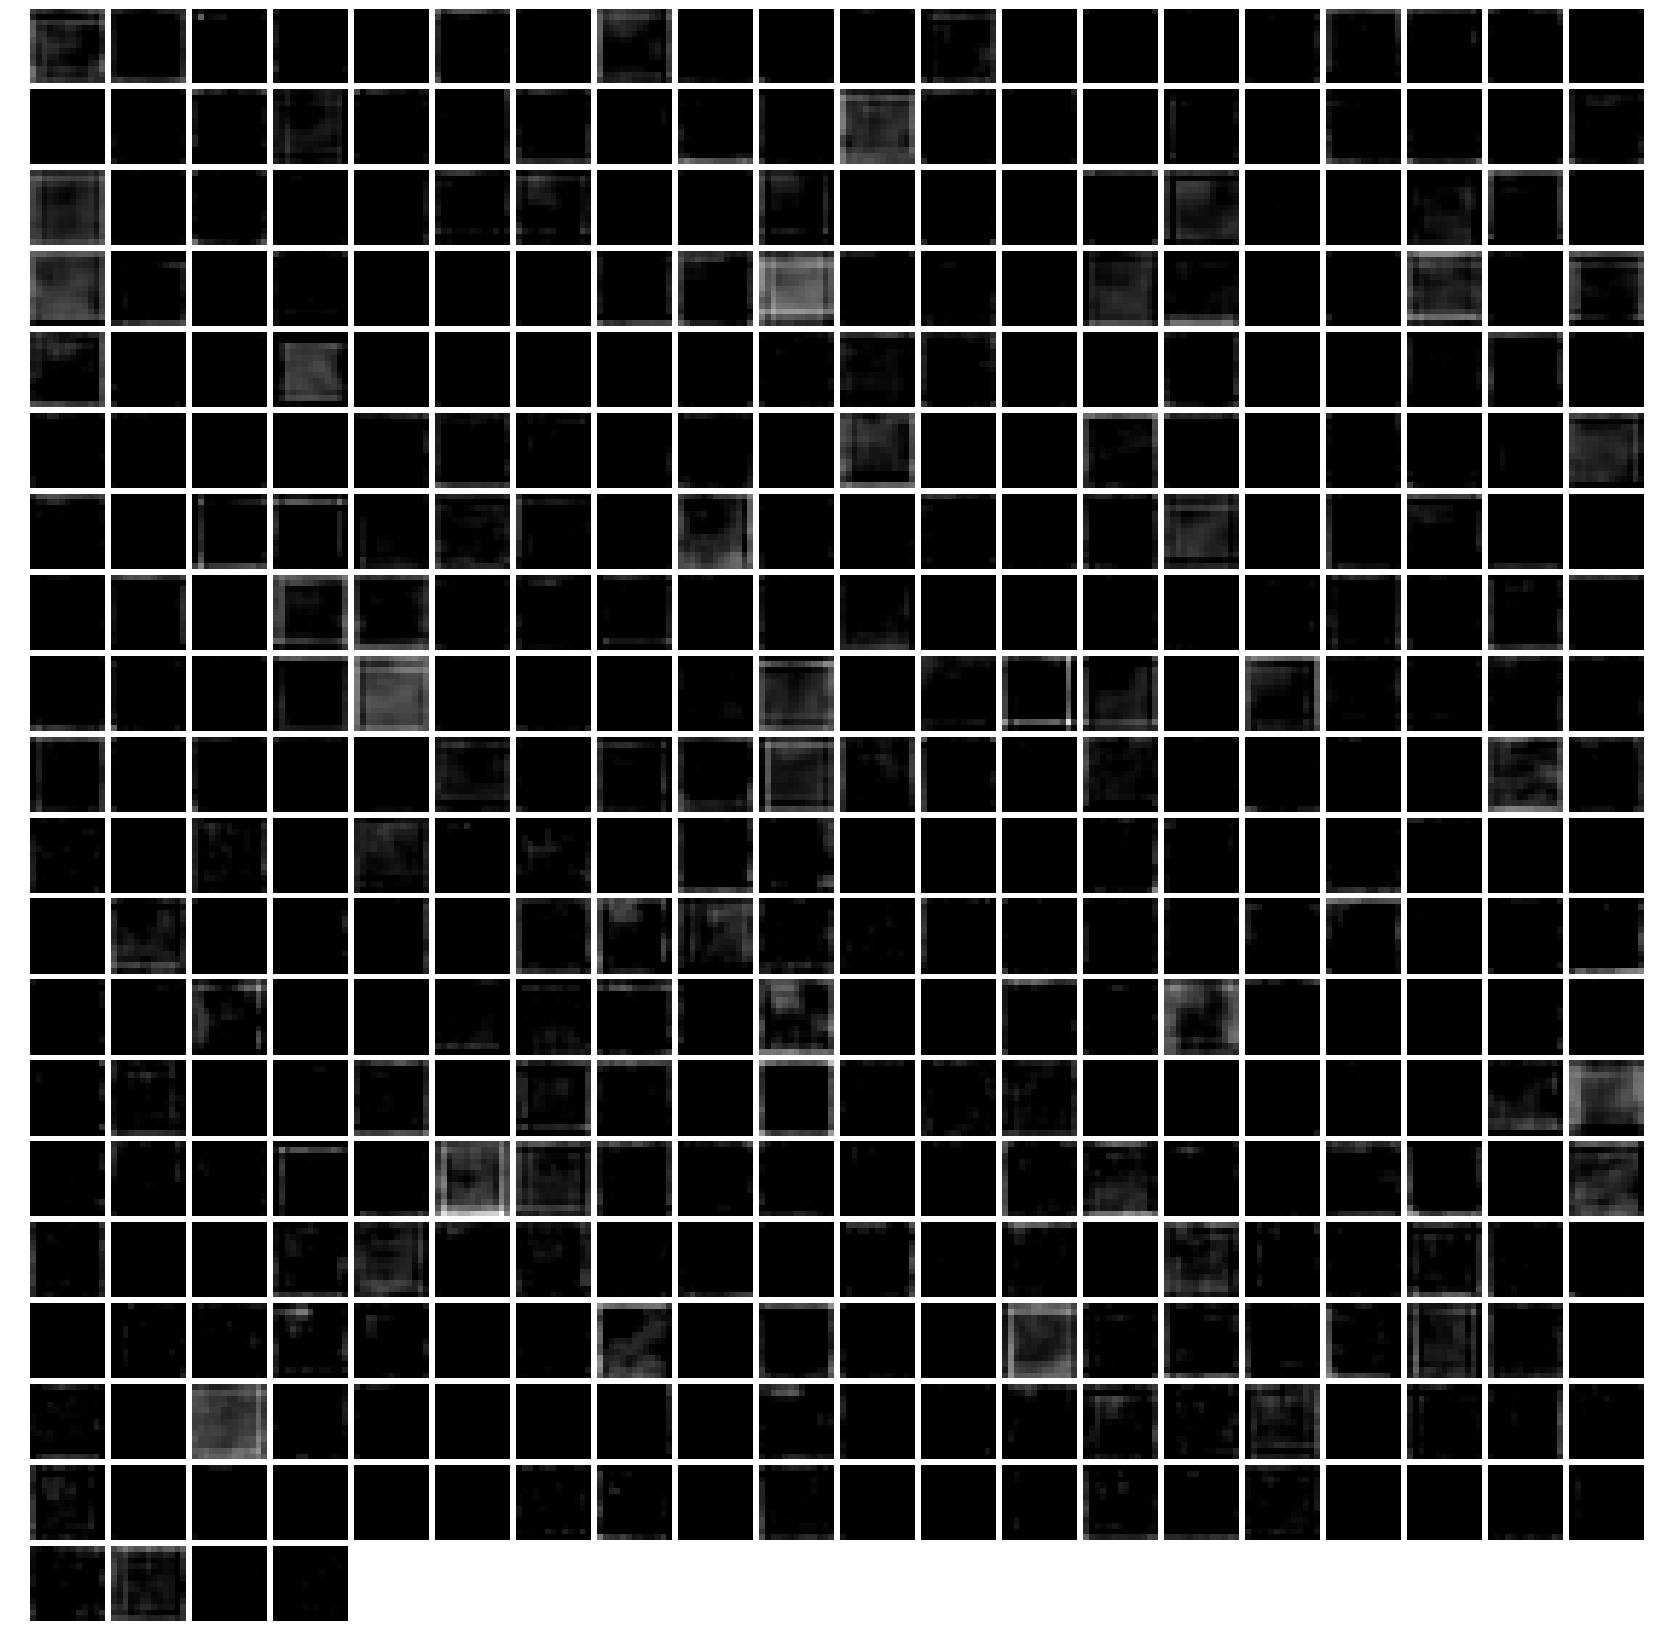

layer[conv4], param_weights.data.shape[(384, 192, 3, 3)]
vis_pretiled: data.shape[(80, 80, 192)]
    Error: Invalid dimensions for image data

layer[conv5]
- blob.data.shape[(50, 256, 13, 13)]
- param_weights.data.shape[(256, 192, 3, 3)]
- param_biases.data.shape[(256,)]

vis_pretiled: data.shape[(224, 224)]


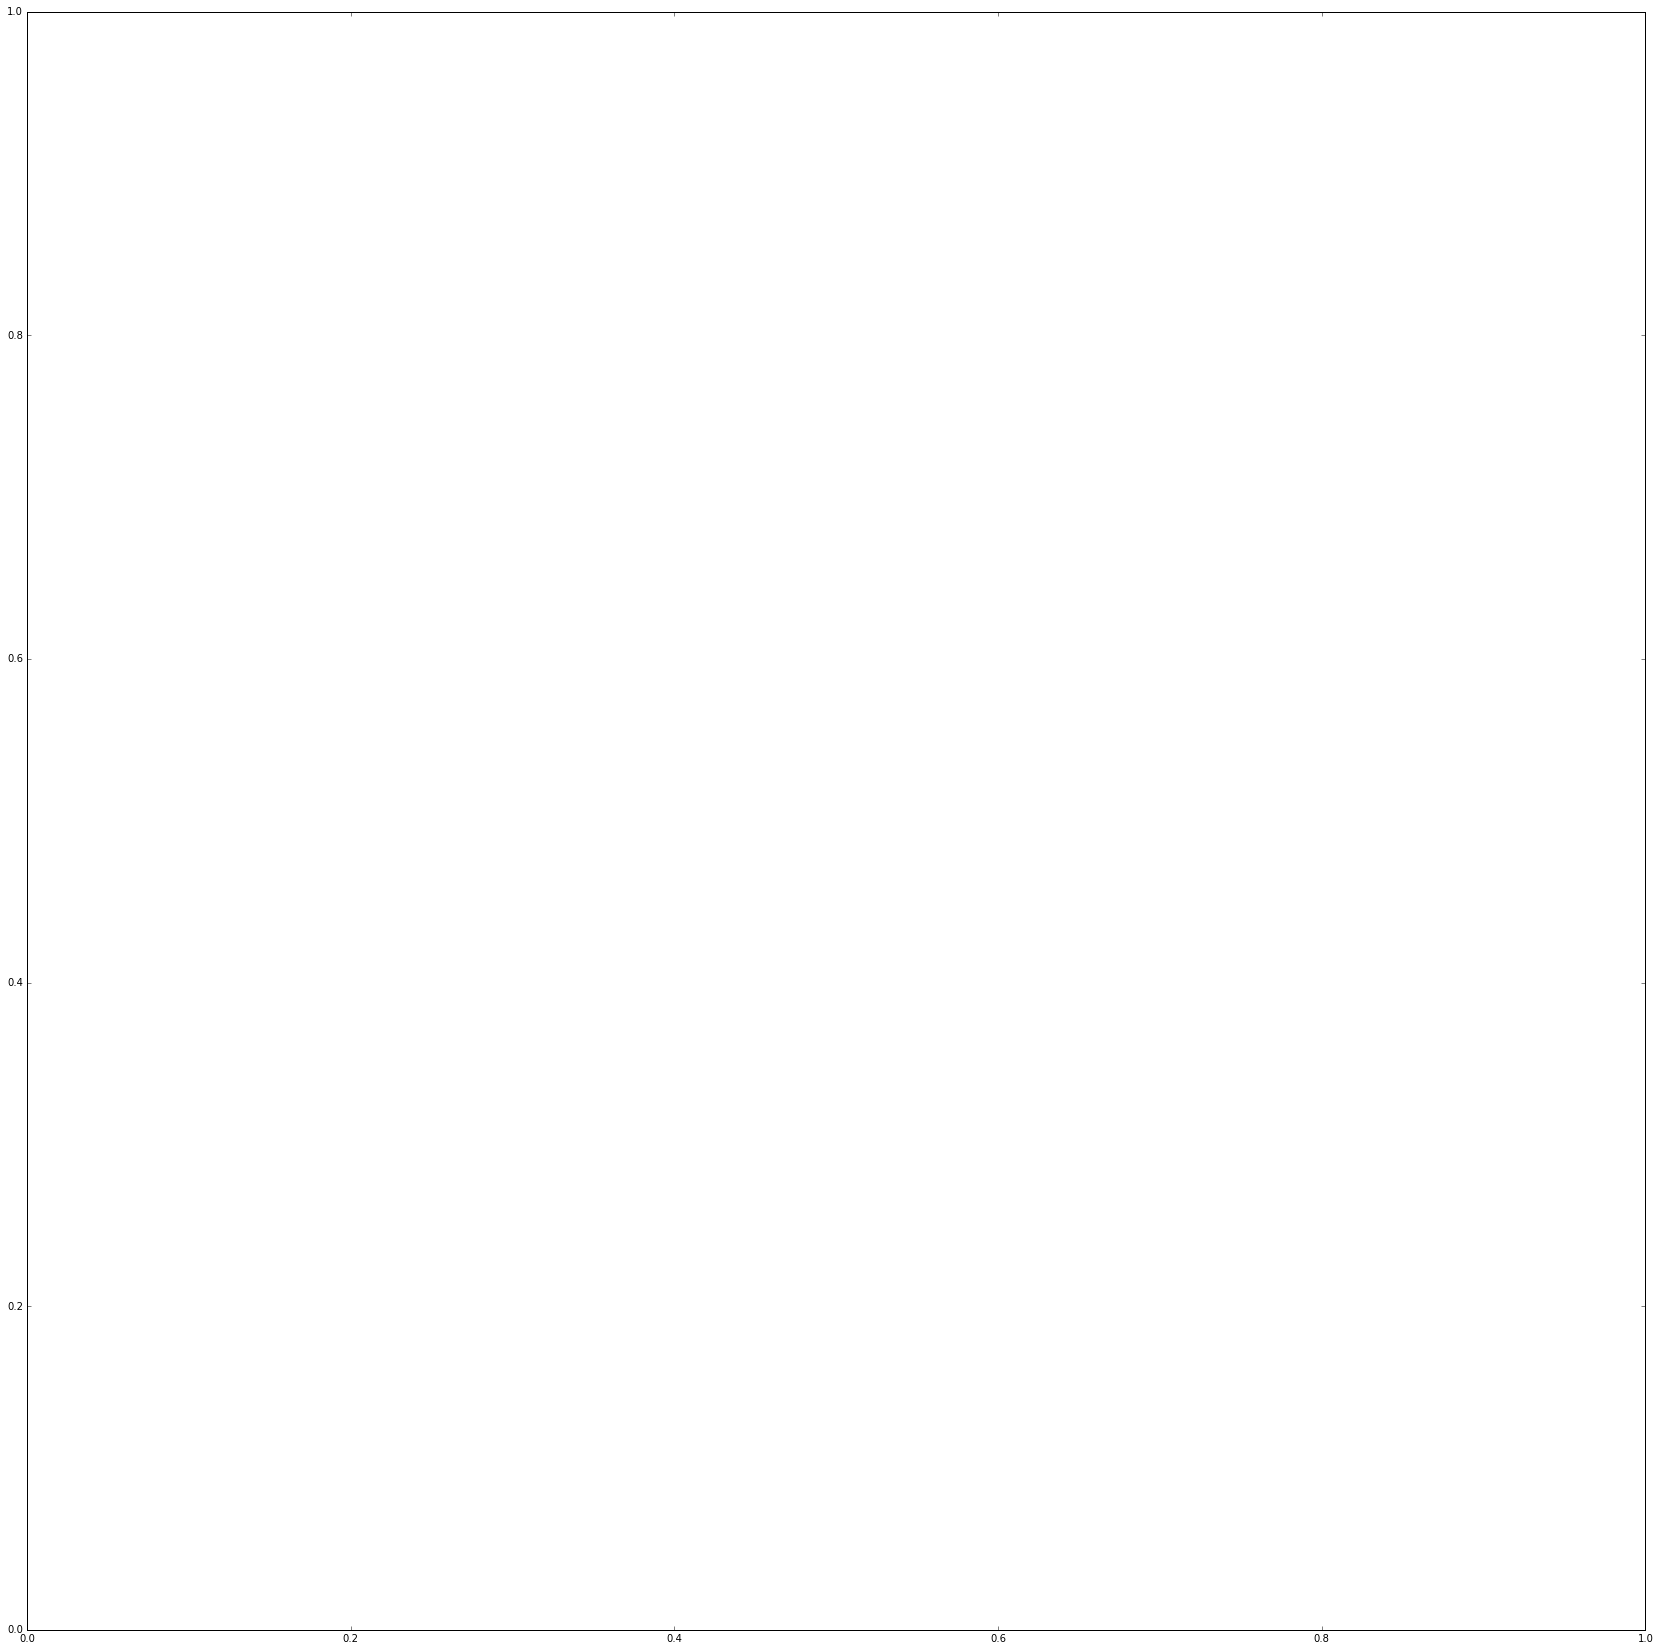

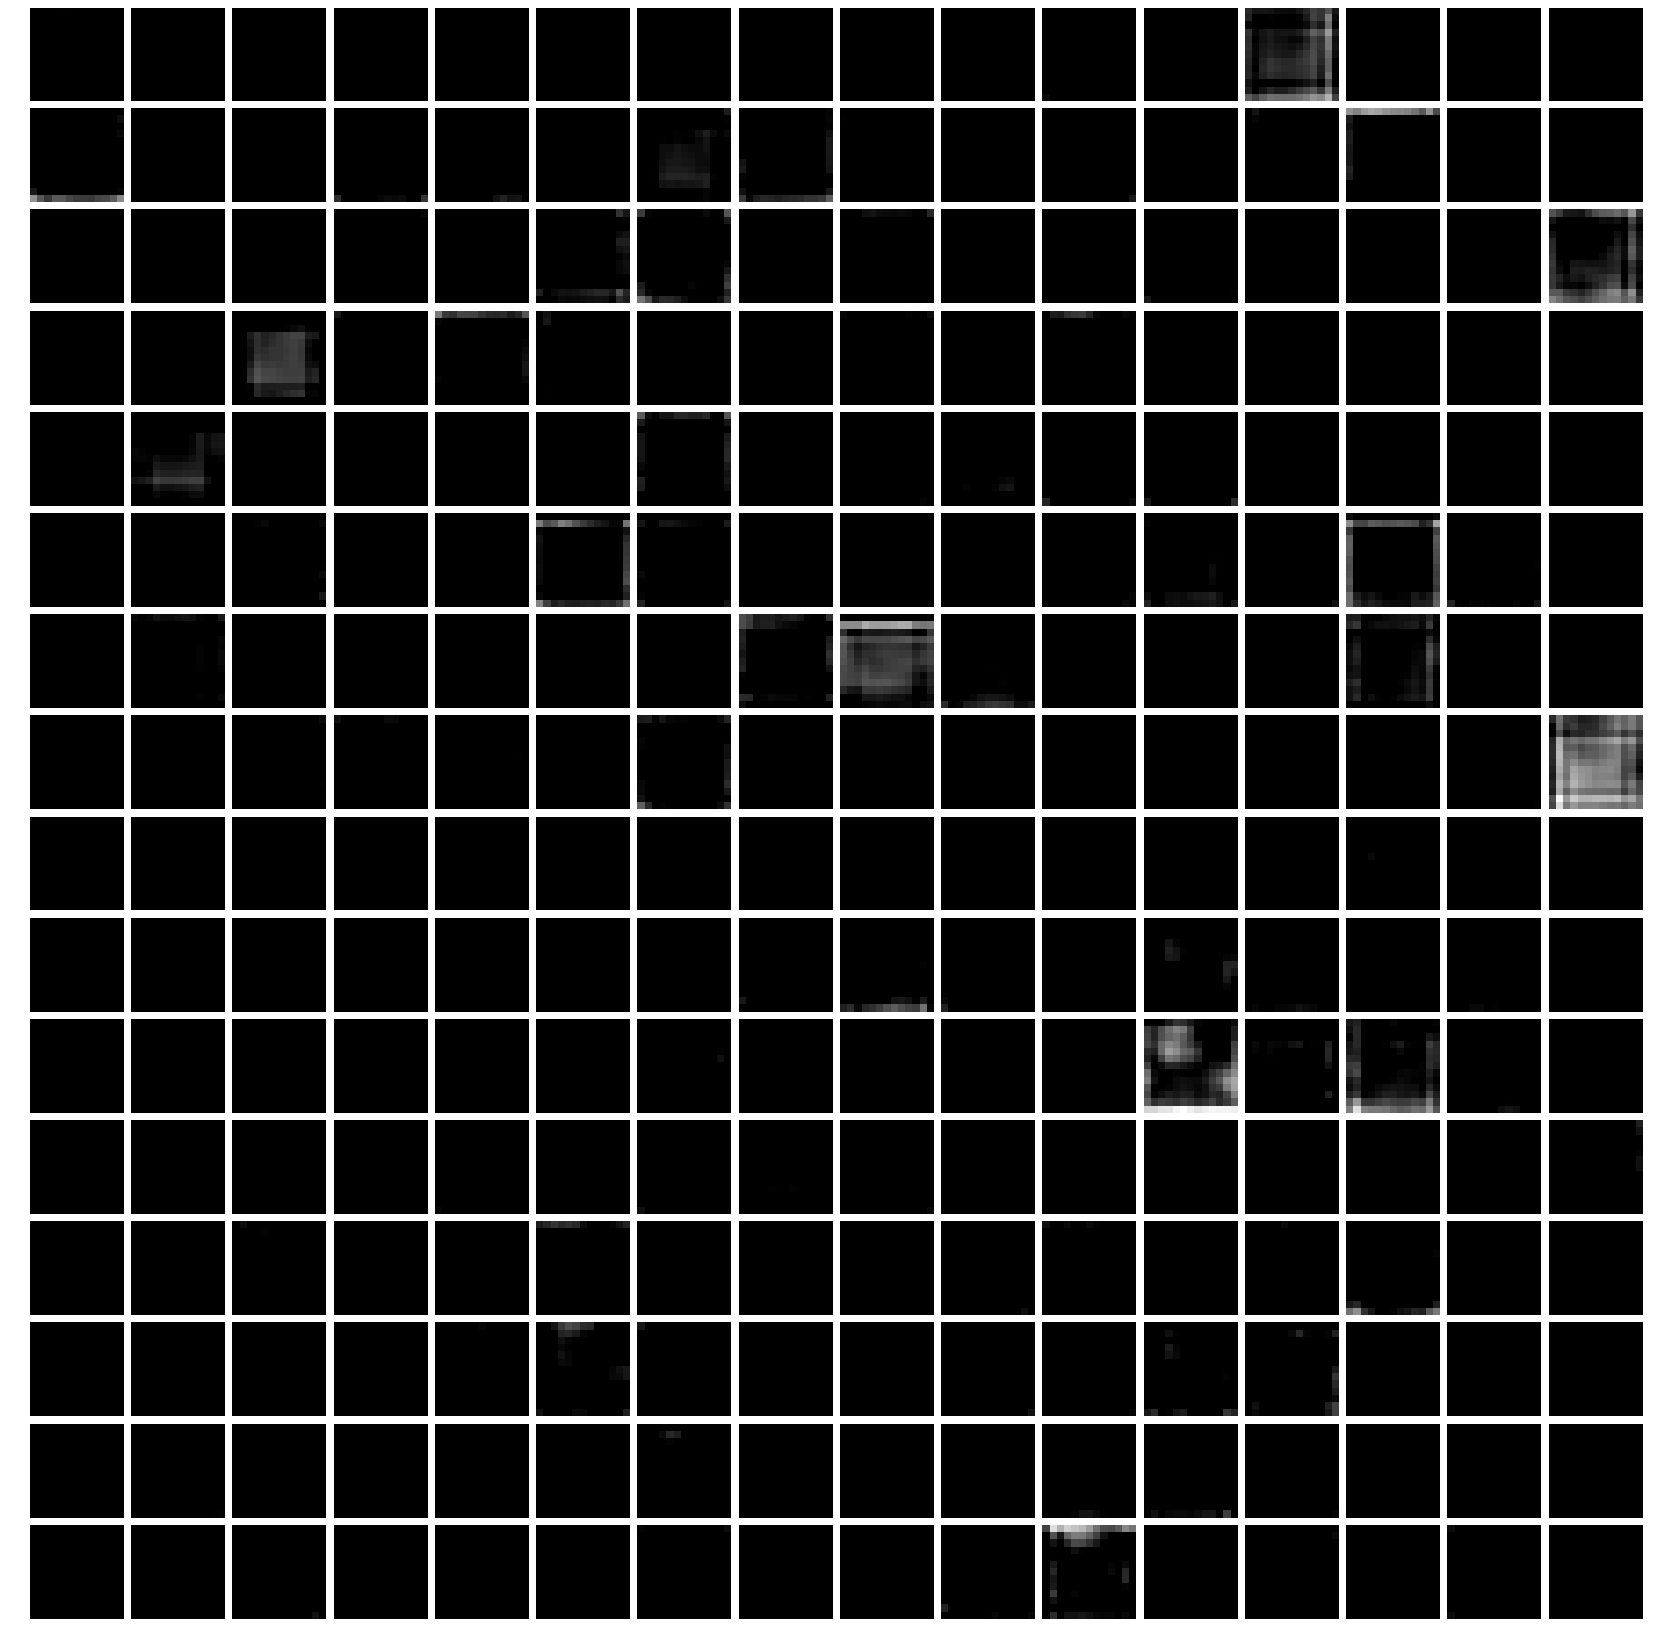

layer[conv5], param_weights.data.shape[(256, 192, 3, 3)]
vis_pretiled: data.shape[(64, 64, 192)]
    Error: Invalid dimensions for image data

layer[pool5]
- blob.data.shape[(50, 256, 6, 6)]
- param_weights.data.shape[None]
- param_biases.data.shape[None]

vis_pretiled: data.shape[(112, 112)]


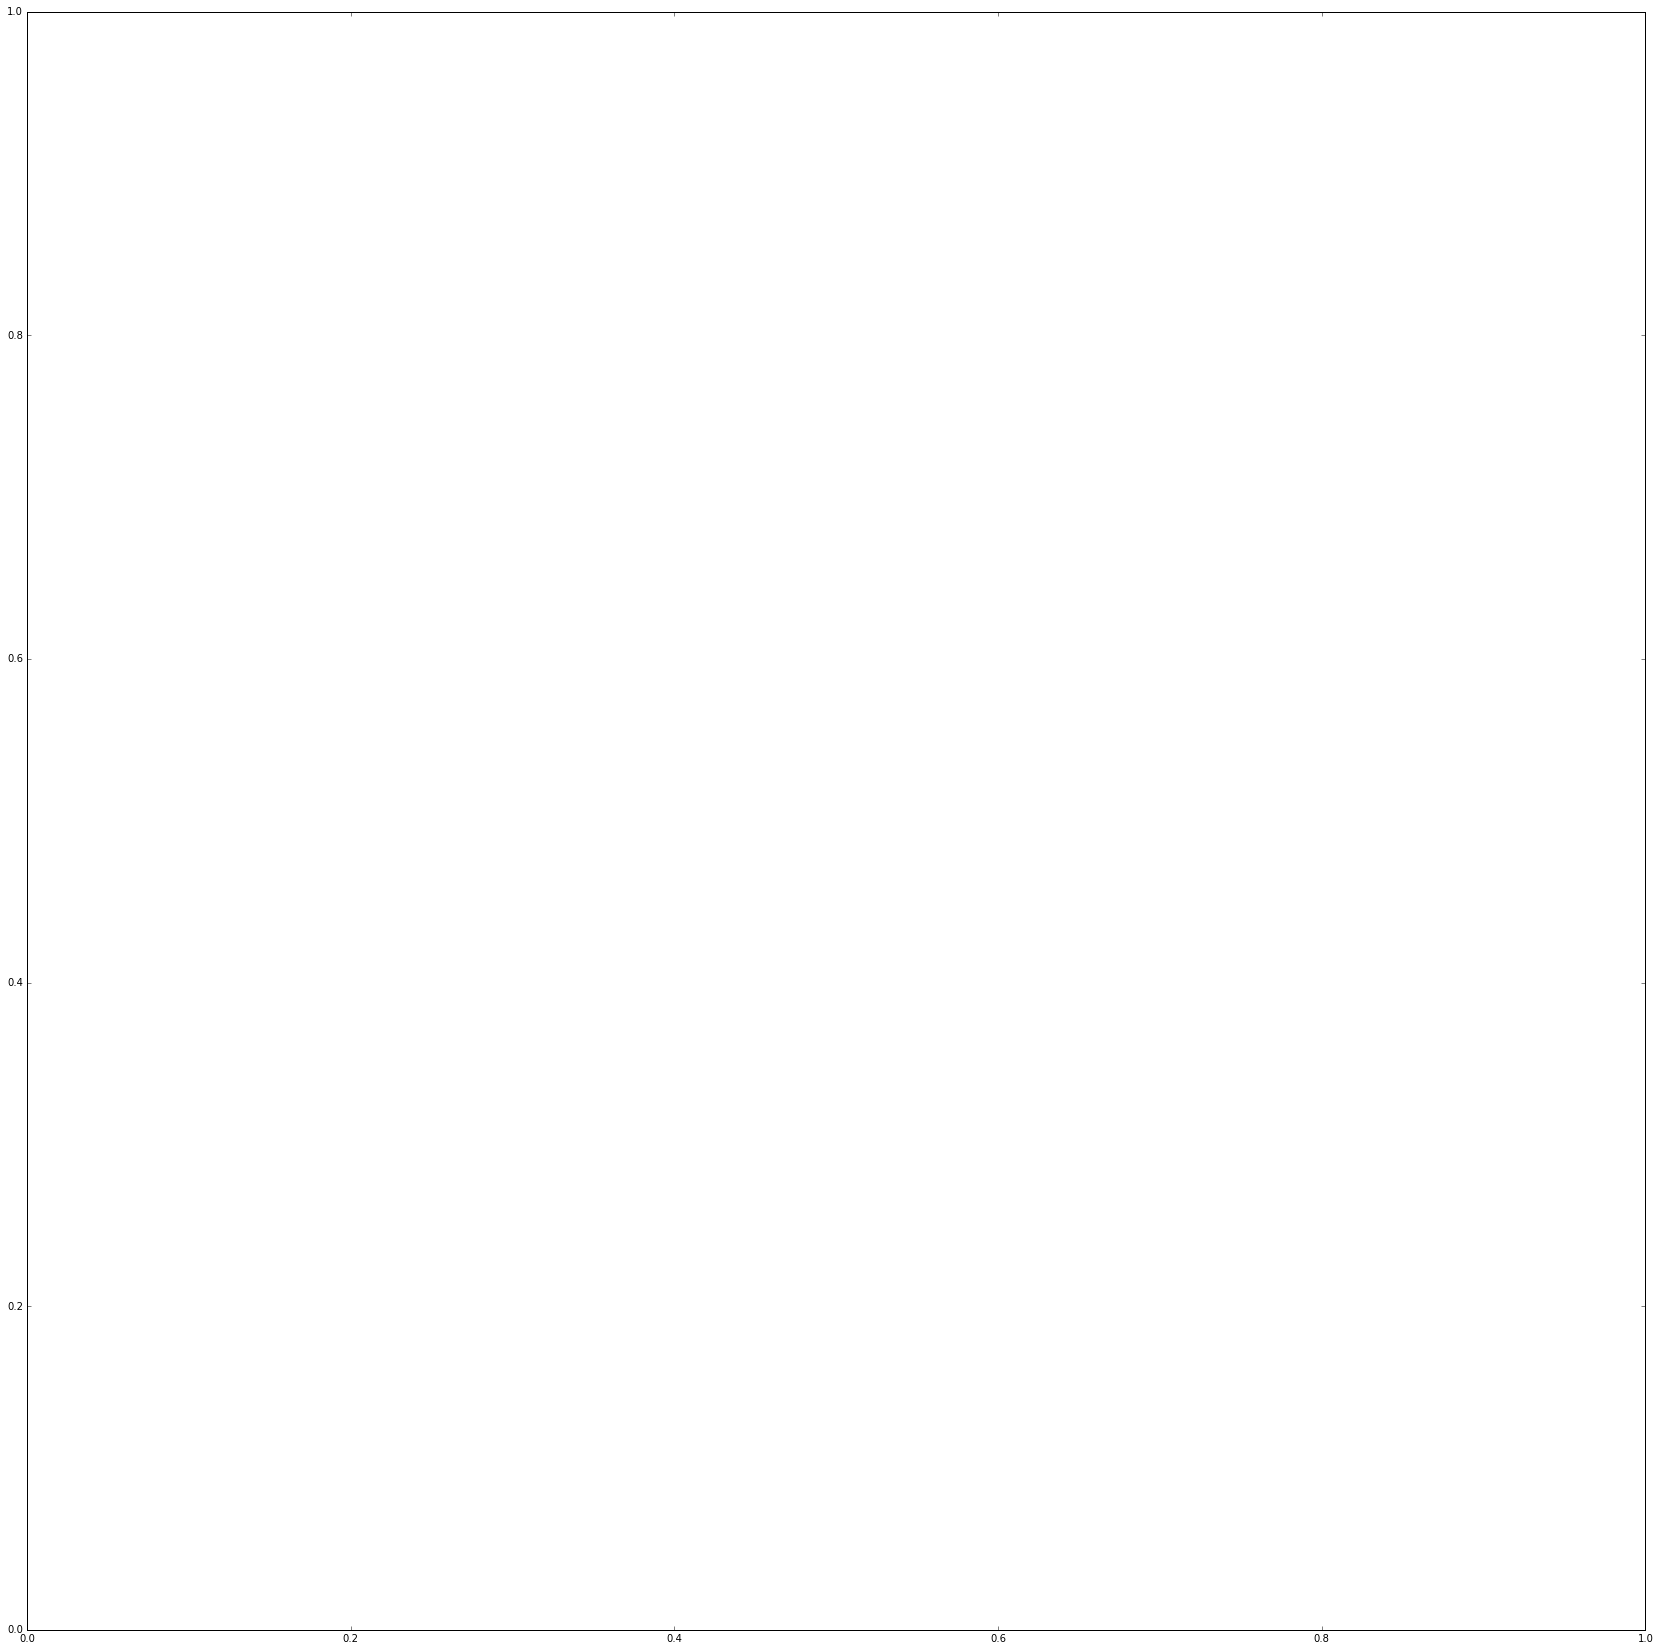

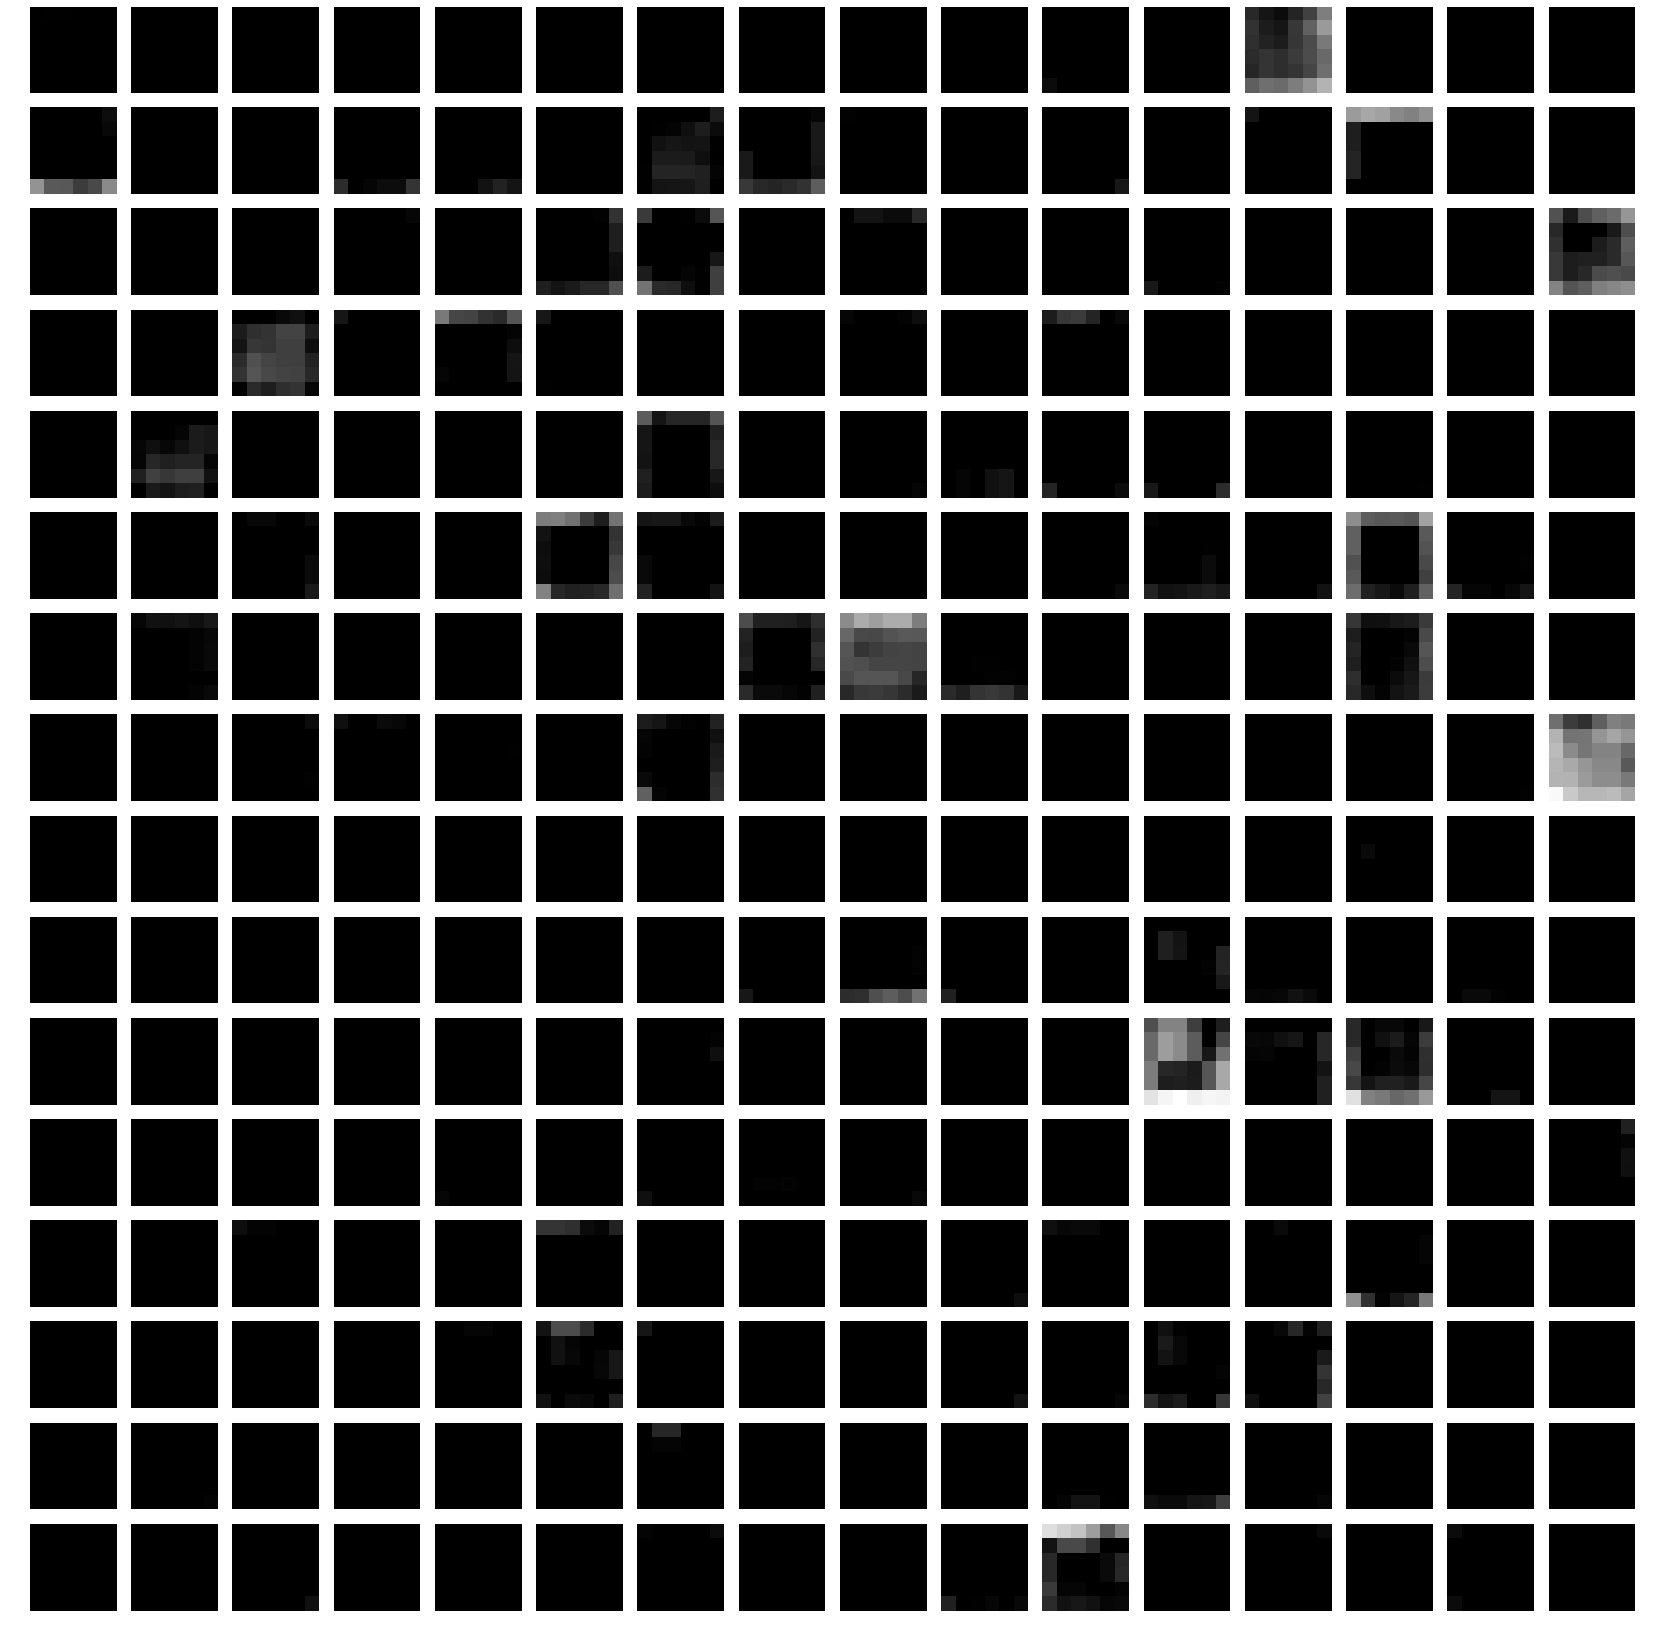

layer[pool5], param_weights[None]

layer[fc6]
- blob.data.shape[(50, 4096)]
- param_weights.data.shape[(4096, 9216)]
- param_biases.data.shape[(4096,)]

    Error: Unable to create correctly shaped tuple from ((0, 0), (0, 1), (0, 1))
layer[fc6], param_weights.data.shape[(4096, 9216)]
    Error: axes don't match array

layer[fc7]
- blob.data.shape[(50, 4096)]
- param_weights.data.shape[(4096, 4096)]
- param_biases.data.shape[(4096,)]

    Error: Unable to create correctly shaped tuple from ((0, 0), (0, 1), (0, 1))
layer[fc7], param_weights.data.shape[(4096, 4096)]
    Error: axes don't match array

layer[fc8]
- blob.data.shape[(50, 1000)]
- param_weights.data.shape[(1000, 4096)]
- param_biases.data.shape[(1000,)]

    Error: Unable to create correctly shaped tuple from ((0, 24), (0, 1), (0, 1))
layer[fc8], param_weights.data.shape[(1000, 4096)]
    Error: axes don't match array

layer[prob]
- blob.data.shape[(50, 1000)]
- param_weights.data.shape[None]
- param_biases.data.shape[None]

 

In [19]:
for layer_name, blob in net.blobs.iteritems():

    [param_weights, param_biases] = net.params.get(layer_name, [None, None])    
    print '\nlayer[%s]\n- blob.data.shape[%s]\n- param_weights.data.shape[%s]\n- param_biases.data.shape[%s]\n' % (
        layer_name,
        blob.data.shape,
        param_weights and param_weights.data.shape,
        param_biases  and param_biases.data.shape,
    )
    
    try:
        vis_square(blob.data[0])
    except Exception, e:
        print '    Error:', e

    if not param_weights:
        print 'layer[%s], param_weights[%s]' % (layer_name, param_weights)
    else:
        print 'layer[%s], param_weights.data.shape[%s]' % (layer_name, param_weights.data.shape)
        try:
            vis_square(param_weights.data.transpose(0, 2, 3, 1)) # e.g. (96,3,11,11) -> (96,11,11,3)
        except Exception, e:
            print '    Error:', e

probabilities and labels:
[(0.15045533, 'n04525038 velvet'),
 (0.13852249, 'n03223299 doormat, welcome mat'),
 (0.12479795, 'n03207743 dishrag, dishcloth'),
 (0.08279831, 'n04599235 wool, woolen, woollen'),
 (0.033983503, 'n03887697 paper towel'),
 (0.022745488, 'n03530642 honeycomb'),
 (0.022661999, 'n04376876 syringe'),
 (0.016129013,
  'n03000247 chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour'),
 (0.011925566, 'n03998194 prayer rug, prayer mat'),
 (0.011500423, 'n02114855 coyote, prairie wolf, brush wolf, Canis latrans'),
 (0.01124437, 'n04332243 strainer'),
 (0.011015759, 'n02454379 armadillo'),
 (0.0097646723, 'n02120505 grey fox, gray fox, Urocyon cinereoargenteus'),
 (0.0097130509, 'n04589890 window screen'),
 (0.0090373242, 'n02219486 ant, emmet, pismire'),
 (0.0090282969, 'n02786058 Band Aid'),
 (0.0074922051, 'n03000134 chainlink fence'),
 (0.0073114005, 'n01756291 sidewinder, horned rattlesnake, Crotalus cerastes'),
 (0.0071736509, 'n03717622

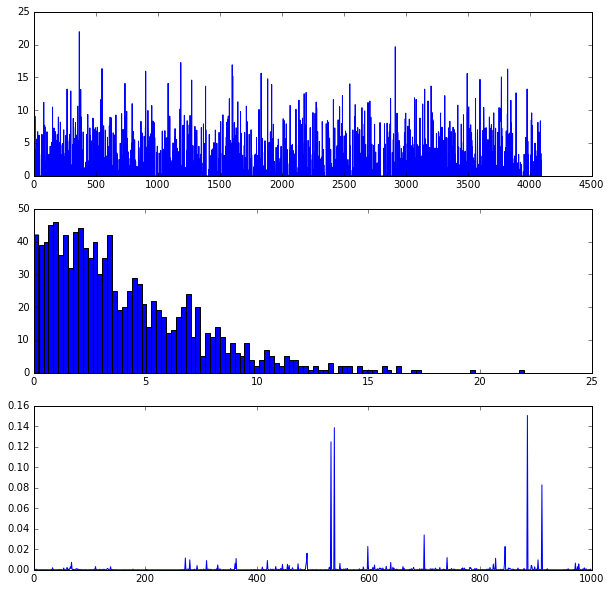

In [23]:
print 'probabilities and labels:'
top_inds = output_prob.argsort()[::-1][:20] # top k predictions from softmax output
pprint(zip(output_prob[top_inds], labels[top_inds]))

# The first fully connected layer, `fc6` (rectified)
# - We show the output values and the histogram of the positive values
plt.subplot(3, 1, 1); plt.plot(net.blobs['fc6'].data[0].flat)
plt.subplot(3, 1, 2); plt.hist(net.blobs['fc6'].data[0].flat[net.blobs['fc6'].data[0].flat > 0], bins=100)

# The final probability output, `prob`
# - Note the cluster of strong predictions; the labels are sorted semantically
# - The top peaks correspond to the top predicted labels, as shown above
plt.subplot(3, 1, 3); plt.plot(net.blobs['prob'].data[0].flat)